In [1]:
import pandas as pd 
import numpy as np
import pickle 
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
from IIASA_22_fxns import tt_split_scale_SCALER
from matplotlib import cm 
from sklearn.neighbors import NearestNeighbors
import scipy.spatial as spatial
from matplotlib.colors import ListedColormap


In [2]:
#### PULL FULL DATASETS FOR ALL CROPS 
crop_list = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']
all_treat_list = []
for crop in crop_list: 
    all_treats = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//"+ crop + "//"+ crop + "_all_treat_data.csv")
    all_treat_list.append(all_treats)

In [3]:
# input full treatment data, return clusters which regressions were trained with 
def get_clusters(all_treats):    
    #### ARGUMENTS FOR CLUSTERING 
    clust_args = []
    for clim in all_treats.k_mean_cluster.unique(): 
        for tex in all_treats.TEXTURE.unique(): 
            clust_args.append((clim, tex))

    #### CLUSTERING - A PRIORI AND UNSUPERVISED 
    # CLUSTER BY CLIMATE - 10 clusters, SOIL - 6 classes, CROP
    cluster_dfs = []
    for arg in clust_args: 
        clim = arg[0]
        tex = arg[1]
        df_clust = all_treats[(all_treats.k_mean_cluster == clim) & (all_treats.TEXTURE == tex)]
        # remove outliers
        cleaned = df_clust[(np.abs(scipy.stats.zscore(df_clust['YLDG'])) < 3) & (np.abs(scipy.stats.zscore(df_clust['mean_OCPD_change'])) < 3)]
        # enforce that there must be at least 1000 points in a cluster to complete analysis
        if len(cleaned) > 1000: 
            cleaned.dropna(inplace = True)
            cluster_dfs.append(cleaned)    
    # append full data 
    all_treats.dropna(inplace = True)
    cluster_dfs.append(all_treats)
    
    return(cluster_dfs)


In [4]:
# cluster_lists 
# first level = crop 
# second level = cluster, last cluster is full data set 
cluster_lists = []
for crop in all_treat_list:
    cluster_dfs = get_clusters(crop)
    cluster_lists.append(cluster_dfs)

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/3254926612.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.dropna(inplace = True)


In [5]:
# get simuid for each cluster
simU_cluster = [list(c.SimUID.unique()) for c in cluster_lists[0]]

In [6]:
# unpickle the variables from regressions for each crop - inside each of these is information on cluster 
# specific regression, full regression. Return unpickled data.

def unpickle(crop):    
    # Open a file and use dump()
    with open(('predict_y_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        predict_y_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('x_trains_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        x_trains_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('x_tests_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        x_tests_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('y_trains_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        y_trains_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('y_tests_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        y_tests_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('train_inds_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        train_inds_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('scores_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        scores_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('regressors_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        regressors_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('loo_scores_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        loo_scores_AT = pickle.load(file)

        
    return([predict_y_AT, x_trains_AT, x_tests_AT, y_trains_AT, y_tests_AT, train_inds_AT, scores_AT, regressors_AT, loo_scores_AT])

In [7]:
# pickle_list 
# first level is crop 
# second level is parameter from model - e.g. x_train_AT
# third level is target 
# fourth level is cluster 

# PULL ALL PICKLES BACK IN FROM MODEL RESULTS 
pickle_list = []
for crop in crop_list: 
    pickle_list.append(unpickle(crop))
    
# ..._pckl
# first level is crop 
# second level is target 
# third level is cluster
    
predict_y_pckl = [pckl[0] for pckl in pickle_list]
x_trains_pckl = [pckl[1] for pckl in pickle_list]
x_tests_pckl = [pckl[2] for pckl in pickle_list]
y_trains_pckl = [pckl[3] for pckl in pickle_list]
y_tests_pckl = [pckl[4] for pckl in pickle_list]
train_inds_pckl = [pckl[5] for pckl in pickle_list]
scores_pckl = [pckl[6] for pckl in pickle_list]
regressors_pckl = [pckl[7] for pckl in pickle_list]
loo_scores_pckl = [pckl[8] for pckl in pickle_list]

In [8]:
#### Inverse transform predicted ocpd 

predicted_list = []
# for each crop
for c in range(len(cluster_lists)):
    # plot preicted values of SOC change versus OC in residues 
    crop_df = cluster_lists[c][-1]
    y, label = pd.factorize(crop_df.SCEN)
    crop_df['CODE'] = y
    X_cols = [col for col in crop_df.columns if col not in ['CROP', 'SCEN', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW', 'mean_OCPD_change', 'YLDG_std', 'mean_OCPD_change_std']]
    scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test, train_ind, scaler_y, scaler_X = tt_split_scale_SCALER(crop_df, "mean_OCPD_change")

    pred_oc = predict_y_pckl[c][1][-1] 

    # inverse transform the test sets accordingly
    OCPD_unscaled = scaler_y.inverse_transform(pred_oc.reshape(-1, 1))
    testX_unscaled = scaler_X.inverse_transform(scaled_X_test)
    
    df = pd.DataFrame()
    df[X_cols] = testX_unscaled
    df['SCEN'] = label[np.array(df.CODE.astype(int))]
    df['predicted_mean_OCPD_change'] = OCPD_unscaled[:, 0]
    df['SimUID'] = df['SimUID'].round().astype(int)
    out = df.merge(crop_df[['SimUID', 'SCEN', 'RW']], how = 'left', on = ['SimUID', 'SCEN'])
    predicted_list.append(out)


### Treatment of Residues and N heatmap

In [9]:
# get simuid for a given cluster and crop 
def get_N_C_table(cluster, crop):
    simU = simU_cluster[cluster]

    # for a given crop, start with corn, get all of the predictions for simulations in that cluster 
    predictions = predicted_list[crop]
    clust_preds = predictions[predictions.SimUID.isin(simU)]

    # make N and res C group columns 
    N_bins = [0, 50, 100, 200, 250, np.inf]
    N_scen = ['0,50', '50,100', '100,200', '200,250', '250+']
    C_bins = [0, 1000, 2000, 3000, 4000, np.inf]
    C_scen = ['0,1', '1,2', '2,3', '3,4', '4+']

    clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
    clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)


    # average response over each management scenario 
    # or average over groupings of N and groupings of C amounts 
    clust_OCPD_av = clust_preds.groupby(["N_scen", 'C_scen']).mean().reset_index()[["N_scen", 'C_scen', 'predicted_mean_OCPD_change', 'FNO3_AGG', 'RSDCa', 'TEXTURE', 'k_mean_cluster']]
    # order the N options properly 
    clust_OCPD_av["N_scen"] = clust_OCPD_av["N_scen"].astype(pd.api.types.CategoricalDtype(categories=['250+', '200,250', '100,200', '50,100', '0,50']))
    # make pivot table
    table = clust_OCPD_av.pivot('N_scen', 'C_scen', 'predicted_mean_OCPD_change').to_numpy()

    return (table)

In [60]:
# for one crop
# crop_list = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']
crop = 7
# save table for each cluster
C_N_tables = []
# save texture and clim cluster info for each 
cluster_info = []
for i in range(43): 
    C_N_tables.append(get_N_C_table(i, crop))
    cluster_info.append((cluster_lists[crop][i].TEXTURE.unique()[0], cluster_lists[crop][i].k_mean_cluster.unique()[0]))

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

In [61]:
# get mins and maxs for plotting - FOR ONE CROP AT A TIME
mins = [np.nanmin(arr) for arr in C_N_tables]
maxs = [np.nanmax(arr) for arr in C_N_tables]
univ_min = min(mins)
univ_max = max(maxs)

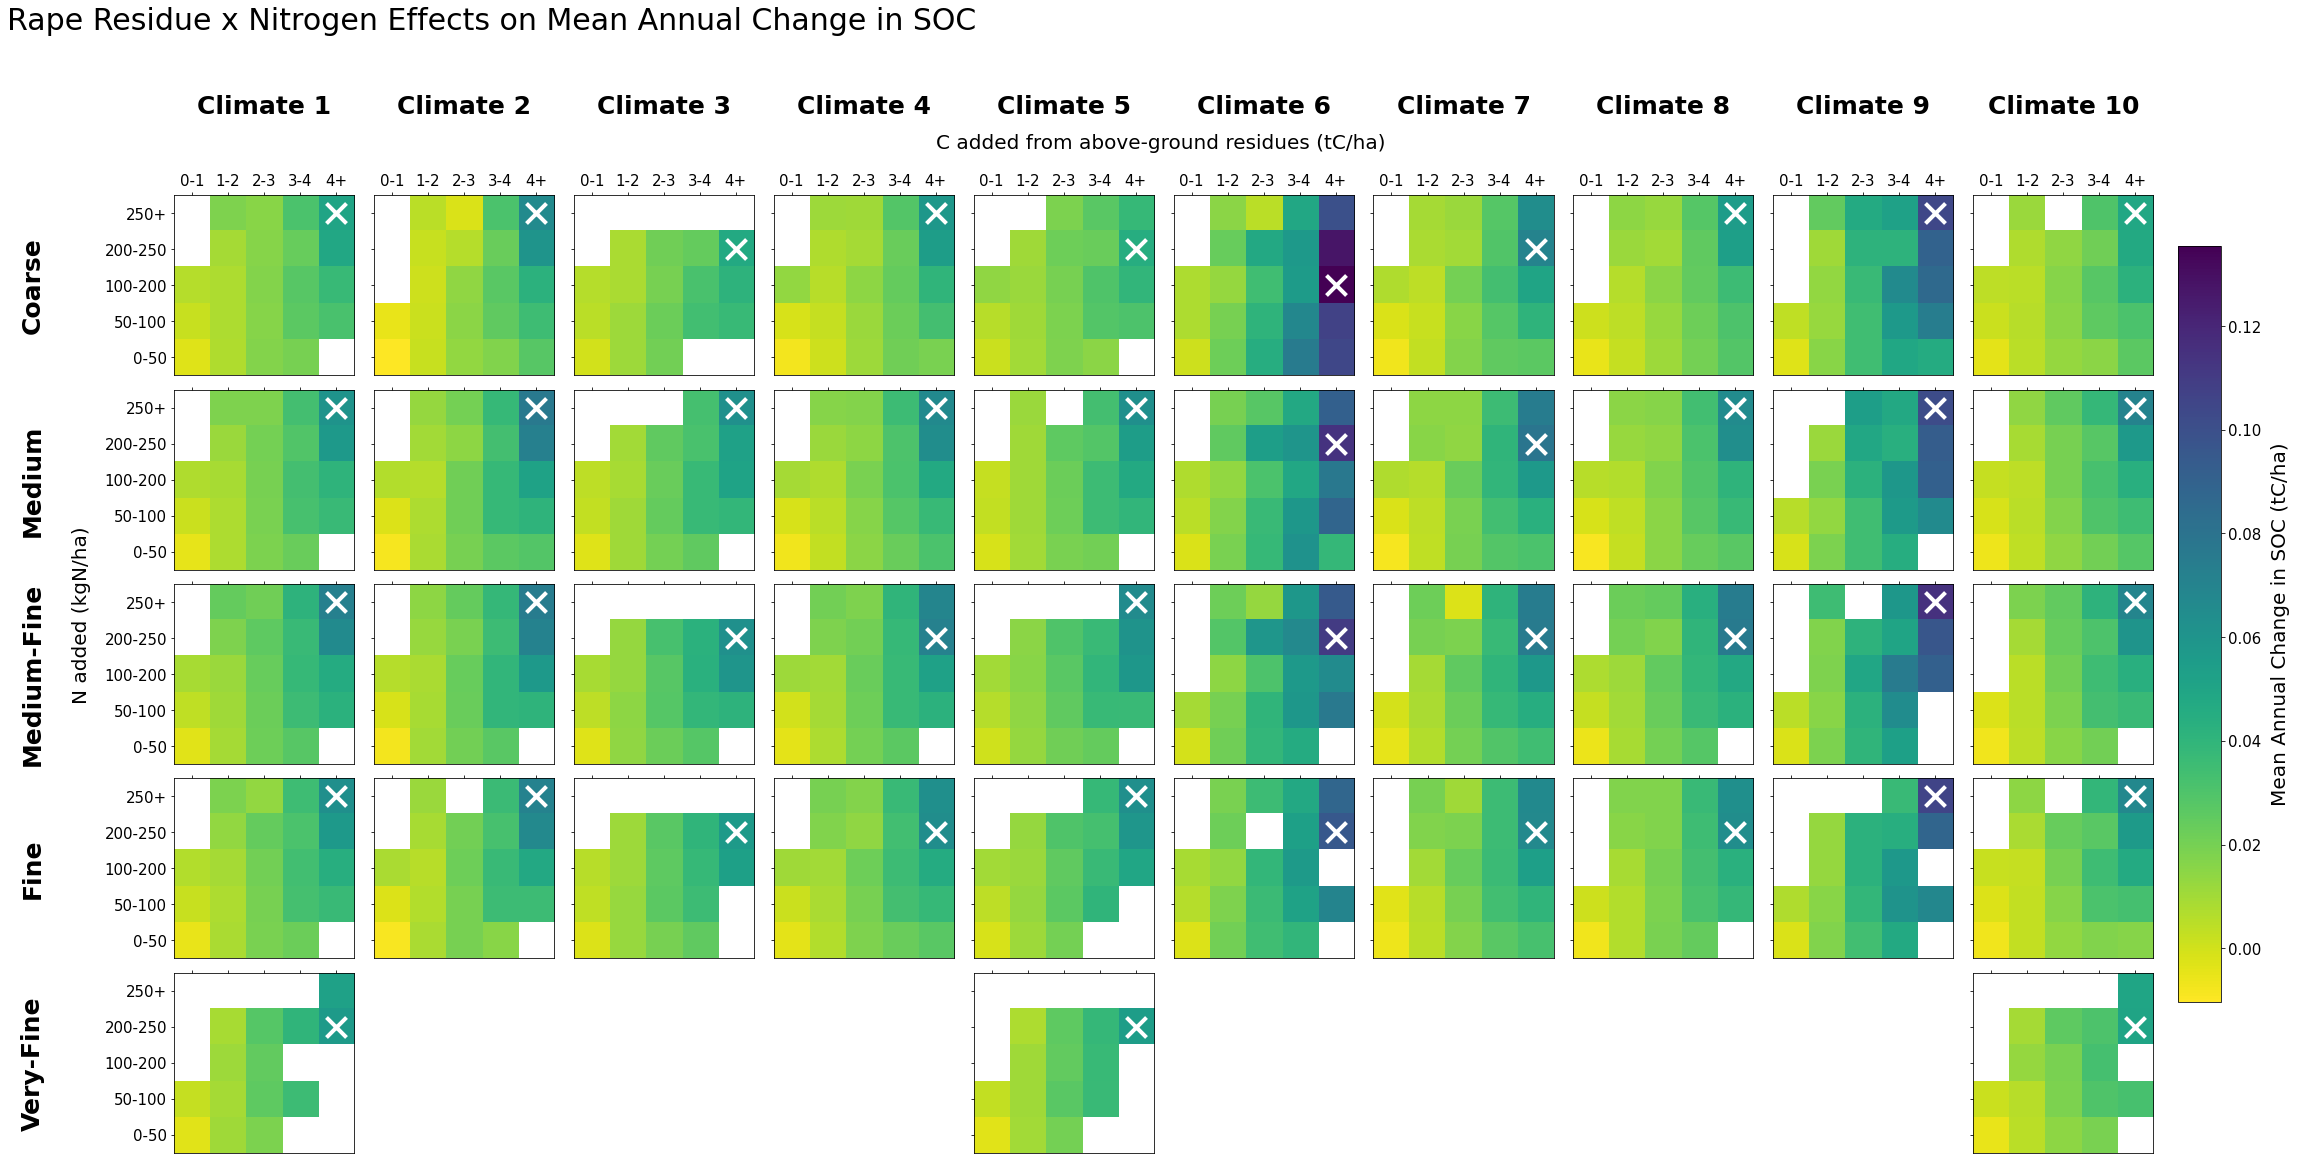

In [62]:
#### HEATMAP OF MEAN OCPD CHANGE WITH RESIDUES AND NITROGEN 
C_scen = ['0-1', '1-2', '2-3', '3-4', '4+']
N_scen = ['250+', '200-250', '100-200', '50-100', '0-50']
soils = ['Coarse', 'Medium', 'Medium-Fine', 'Fine', 'Very-Fine']
clims = ['Climate 1','Climate 2','Climate 3','Climate 4','Climate 5','Climate 6','Climate 7','Climate 8','Climate 9','Climate 10' ]
Tot = 50
Cols = 10
Rows = 5

fig, axs = plt.subplots(nrows = 5, ncols = 10, figsize = (30,15), sharex = True, sharey = True)
# make a counter for table indexing
table_count = 0

for k in range(1,Tot+1):
    # 
    if k in [5, 15, 20, 25, 35, 40, 45]: 
        # row is soil, column is clim cluster
        row, column = int(cluster_info[table_count-1][0]), int(cluster_info[table_count-1][1])
        axs[row][column].axis('off')
    else: 
        # row is soil, column is clim cluster
        row, column = int(cluster_info[table_count][0]-1), int(cluster_info[table_count][1])
        table = C_N_tables[table_count]
        table_count+=1
      # create subplot
        im = axs[row][column].imshow(table, cmap = "viridis_r", vmin = univ_min, vmax = univ_max)
        axs[row][column].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop = False)
        axs[row][column].scatter(np.argwhere(table == np.nanmax(table))[0][1], np.argwhere(table == np.nanmax(table))[0][0], marker="x", color="white", s=400, linewidth = 4)

for i in range(10): 
    axs[0][i].set_xlabel(clims[i], fontsize = 25, labelpad = 60, weight = 'bold')
    axs[0][i].xaxis.set_label_position('top')
    axs[0][i].set_xticks([0,1,2,3,4])    
    axs[0][i].set_xticklabels(C_scen)
    axs[0][i].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop = True, labelsize = 15)

    
for i in range(5): 
    axs[i][0].set_ylabel(soils[i], fontsize = 25, labelpad = 60, weight = 'bold')
    axs[i][0].set_yticks([0,1,2,3,4])    
    axs[i][0].set_yticklabels(N_scen)
    axs[i][0].tick_params(axis = 'y', which = 'both', labelsize = 15)
    
fig.text(.43, .94, "C added from above-ground residues (tC/ha)", fontsize = 20)
fig.text(.03, .43, "N added (kgN/ha)", fontsize = 20, rotation = 90)
fig.text(0, 1.05, "Rape Residue x Nitrogen Effects on Mean Annual Change in SOC", fontsize = 30)
plt.tight_layout()
cbar_ax = fig.add_axes([1.005, 0.15, 0.02, 0.7])
cb = plt.colorbar(im, cbar_ax)
cb.set_label(label = "Mean Annual Change in SOC (tC/ha)",size=20, labelpad = 10)
cb.ax.tick_params(labelsize=15)
# plt.show()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//decision_heatmap_Rape.jpg", bbox_inches = 'tight')


In [15]:
# to average over crops for each cluster
# crop_list = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']

# save table for each cluster
C_N_tables_av_for_clust = []
# save texture and clim cluster info for each 
cluster_info = []
# for each cluster
for i in range(43): 
    cluster_info.append((cluster_lists[0][i].TEXTURE.unique()[0], cluster_lists[0][i].k_mean_cluster.unique()[0]))
    C_N_tables = []
    # for each crop
    for j in range(8): 
        C_N_tables.append(get_N_C_table(i, j))
    mean_across_crop = np.nanmean(C_N_tables, axis=0)
    C_N_tables_av_for_clust.append(mean_across_crop)

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/2236112022.py:15: RuntimeWarning: 

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/2236112022.py:15: RuntimeWarning: Mean of empty slice
  mean_across_crop = np.nanmean(C_N_tables, axis=0)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clus

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/2236112022.py:15: RuntimeWarning: Mean of empty slice
  mean_across_crop = np.nanmean(C_N_tables, axis=0)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_p

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyW

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/2236112022.py:15: RuntimeWarning: Mean of empty slice
  mean_across_crop = np.nanmean(C_N_tables, axis=0)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_p

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['N_scen'] = pd.cut(clust_preds['FNO3_AGG'], N_bins, labels=N_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clust_preds['C_scen'] = pd.cut(clust_preds['RSDCa'], C_bins, labels=C_scen)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48388/1810896827.py:15: SettingWithCopyW

In [25]:
C_N_tables[7]

array([[        nan,         nan,         nan,         nan,         nan],
       [        nan,  0.00741464,  0.02564611,  0.03826968,  0.05448153],
       [        nan,  0.01076898,  0.02502422,  0.03719448,         nan],
       [ 0.0029005 ,  0.01048943,  0.02683799,  0.0366969 ,         nan],
       [-0.00362914,  0.00994092,  0.02019835,         nan,         nan]])

In [89]:
# get mins and maxs for plotting - ALL CROPS AVERAGED FOR EACH CLUSTER
mins = [np.nanmin(arr) for arr in C_N_tables_av_for_clust]
maxs = [np.nanmax(arr) for arr in C_N_tables_av_for_clust]
univ_min = min(mins)
univ_max = max(maxs)

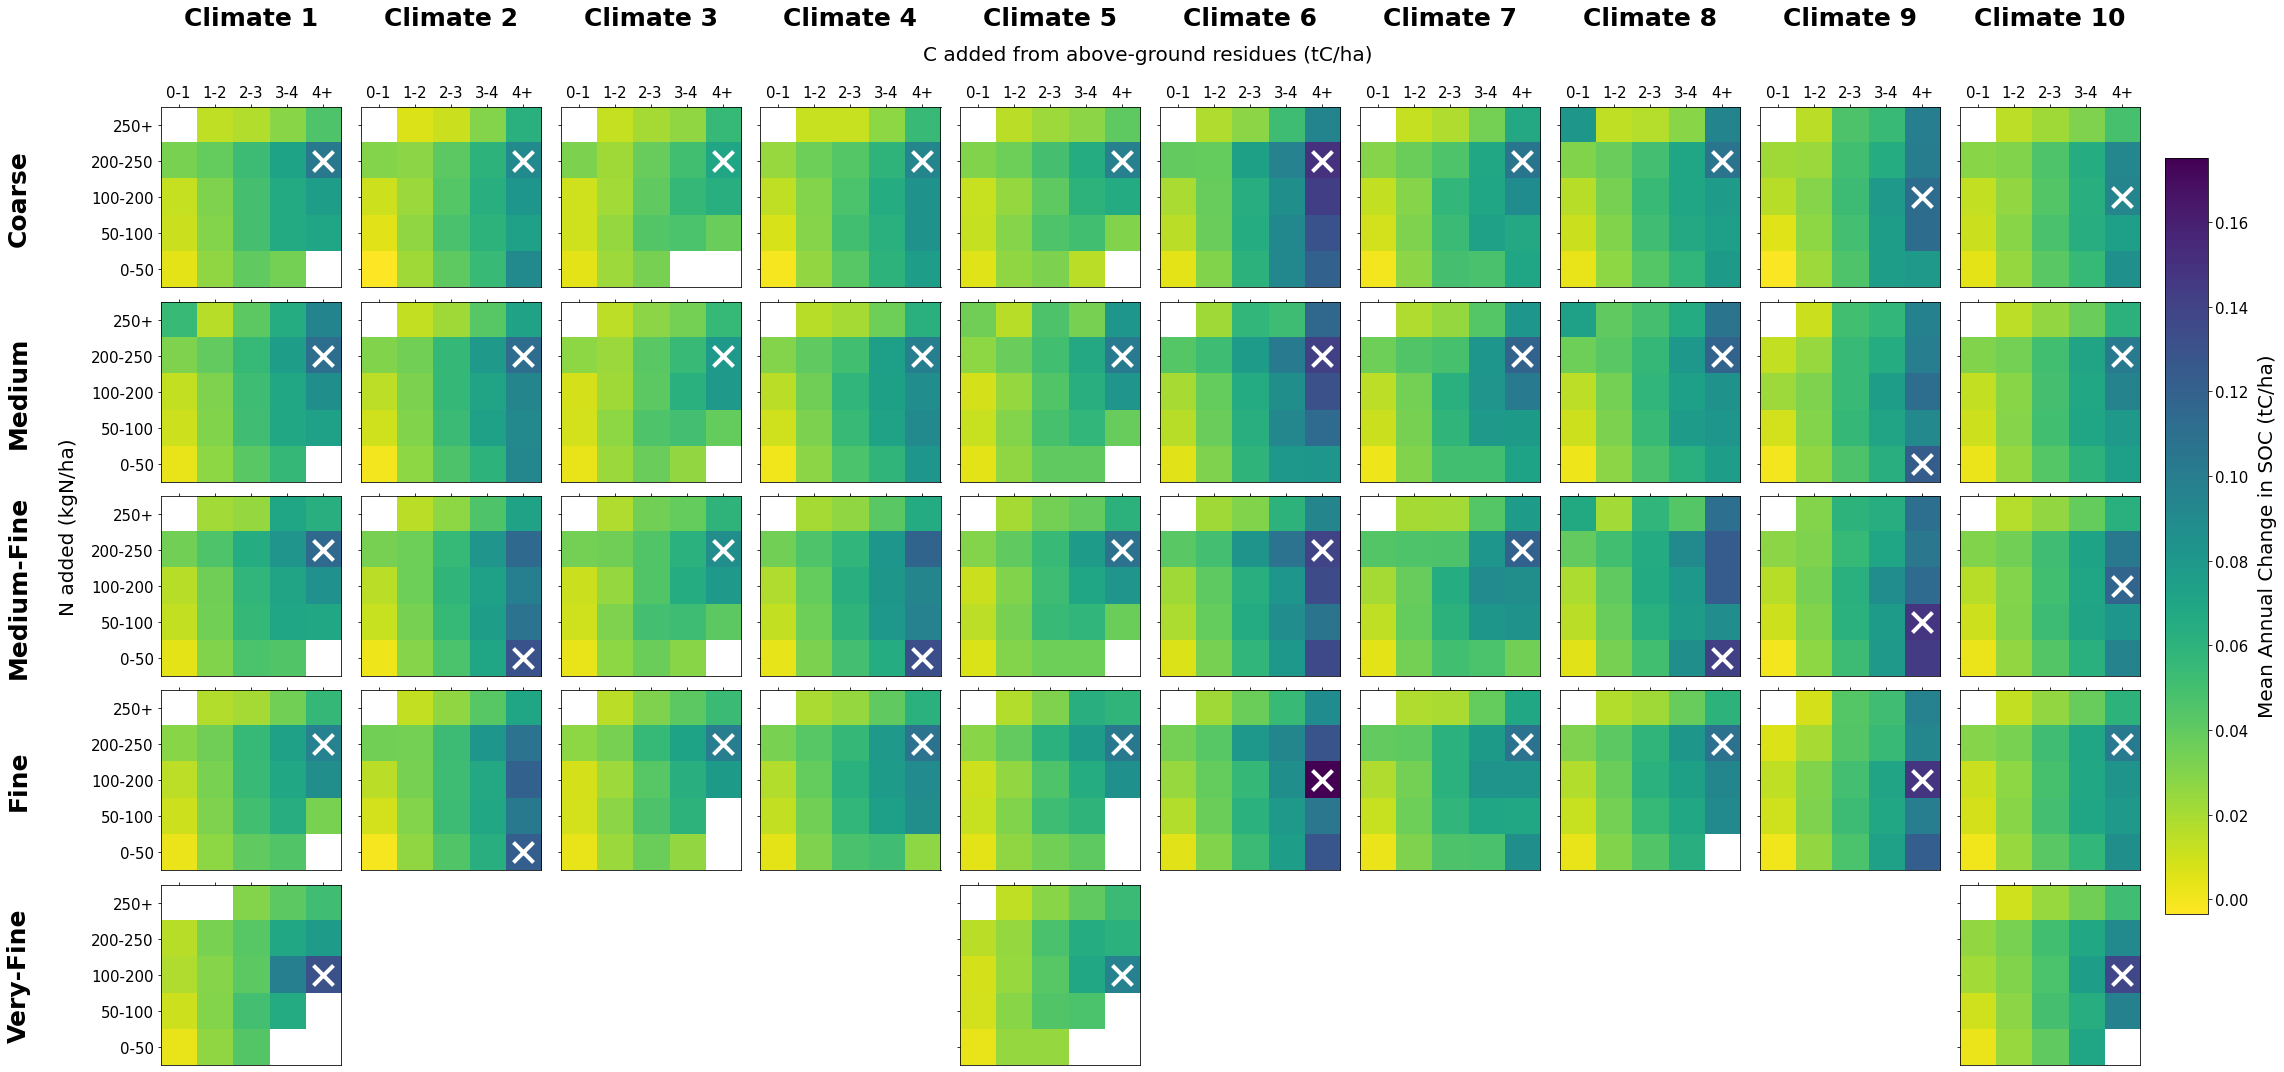

In [114]:
#### HEATMAP OF MEAN OCPD CHANGE WITH RESIDUES AND NITROGEN 
C_scen = ['0-1', '1-2', '2-3', '3-4', '4+']
N_scen = ['250+', '200-250', '100-200', '50-100', '0-50']
soils = ['Coarse', 'Medium', 'Medium-Fine', 'Fine', 'Very-Fine']
clims = ['Climate 1','Climate 2','Climate 3','Climate 4','Climate 5','Climate 6','Climate 7','Climate 8','Climate 9','Climate 10' ]
Tot = 50
Cols = 10
Rows = 5

fig, axs = plt.subplots(nrows = 5, ncols = 10, figsize = (30,15), sharex = True, sharey = True)
# make a counter for table indexing
table_count = 0

for k in range(1,Tot+1):
    # 
    if k in [5, 15, 20, 25, 35, 40, 45]: 
        # row is soil, column is clim cluster
        row, column = int(cluster_info[table_count-1][0]), int(cluster_info[table_count-1][1])
        axs[row][column].axis('off')
    else: 
        # row is soil, column is clim cluster
        row, column = int(cluster_info[table_count][0]-1), int(cluster_info[table_count][1])
        table = C_N_tables_av_for_clust[table_count]
        table_count+=1
      # create subplot
        im = axs[row][column].imshow(table, cmap = "viridis_r", vmin = univ_min, vmax = univ_max)
        axs[row][column].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop = False)
        axs[row][column].scatter(np.argwhere(table == np.nanmax(table))[0][1], np.argwhere(table == np.nanmax(table))[0][0], marker="x", color="white", s=400, linewidth = 4)

for i in range(10): 
    axs[0][i].set_xlabel(clims[i], fontsize = 25, labelpad = 60, weight = 'bold')
    axs[0][i].xaxis.set_label_position('top')
    axs[0][i].set_xticks([0,1,2,3,4])    
    axs[0][i].set_xticklabels(C_scen)
    axs[0][i].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop = True, labelsize = 15)

    
for i in range(5): 
    axs[i][0].set_ylabel(soils[i], fontsize = 25, labelpad = 60, weight = 'bold')
    axs[i][0].set_yticks([0,1,2,3,4])    
    axs[i][0].set_yticklabels(N_scen)
    axs[i][0].tick_params(axis = 'y', which = 'both', labelsize = 15)
    
fig.text(.43, .94, "C added from above-ground residues (tC/ha)", fontsize = 20)
fig.text(.03, .43, "N added (kgN/ha)", fontsize = 20, rotation = 90)
plt.tight_layout()
cbar_ax = fig.add_axes([1.005, 0.15, 0.02, 0.7])
cb = plt.colorbar(im, cbar_ax)
cb.set_label(label = "Mean Annual Change in SOC (tC/ha)",size=20, labelpad = 10)
cb.ax.tick_params(labelsize=15)
# plt.show()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//decision_heatmap_CROP_AVG.jpg", bbox_inches = 'tight')


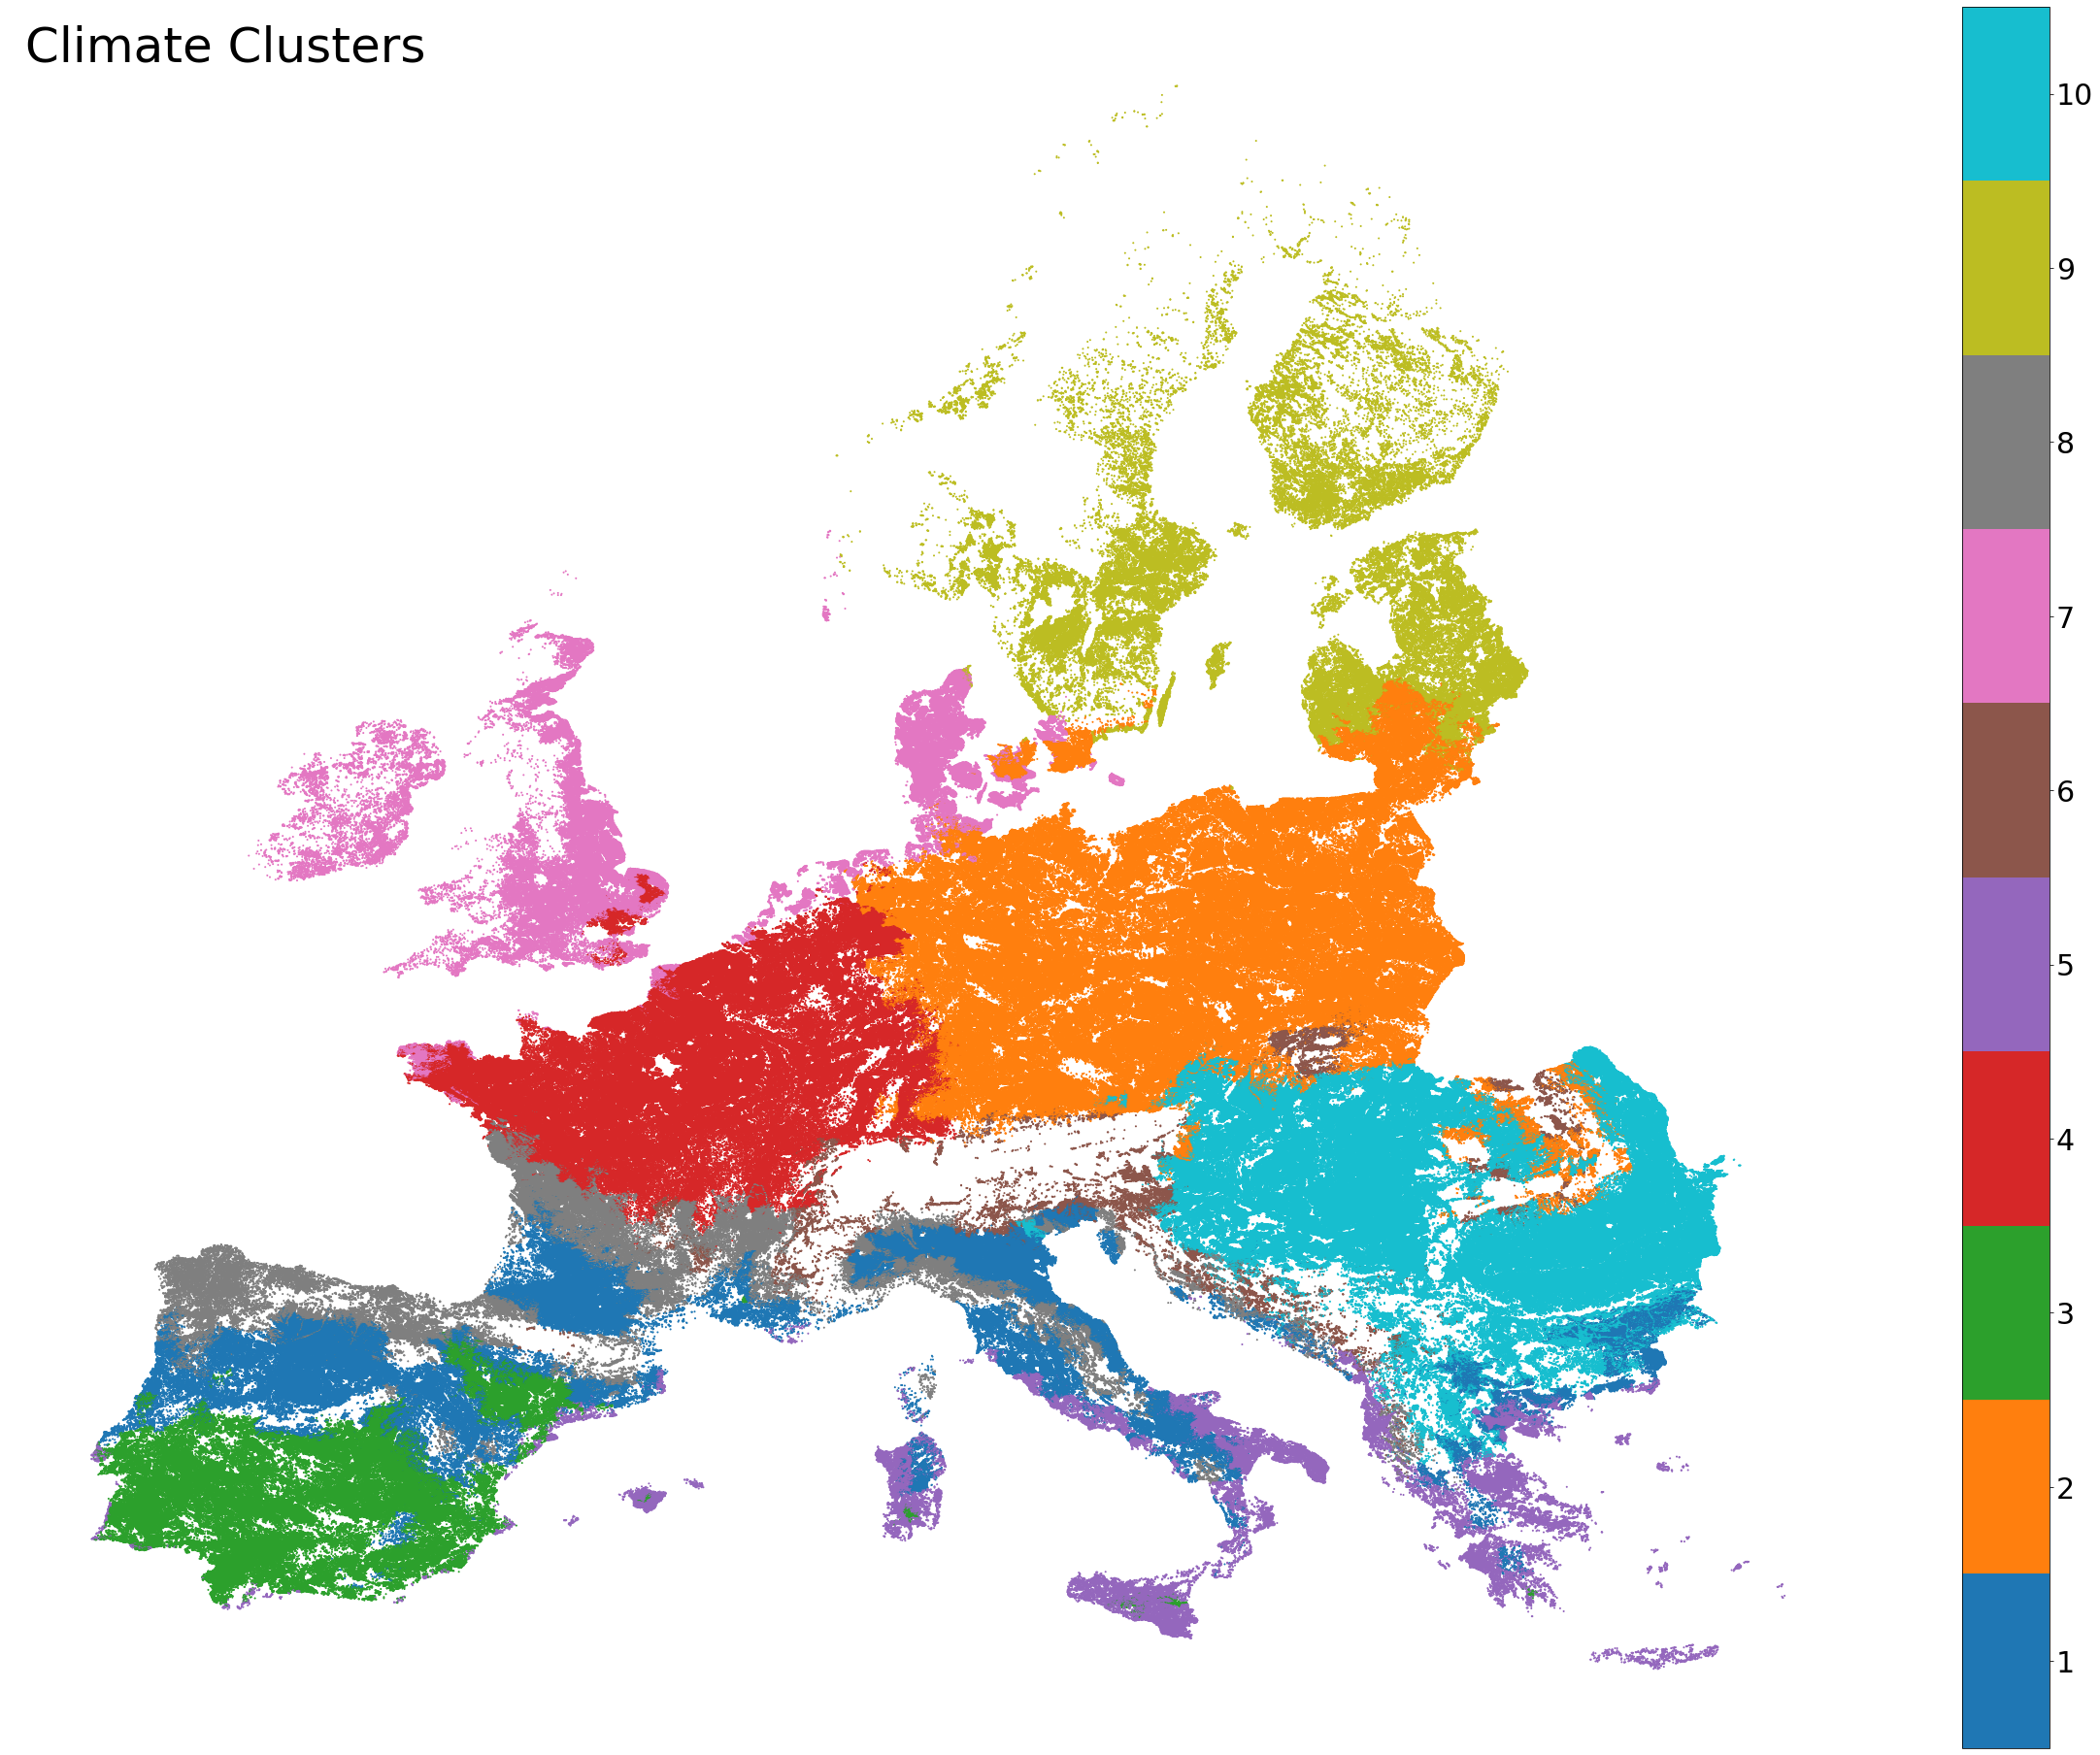

In [118]:
#### with the map 
clim_info = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//climate_PCA_x_simUID.csv")[['SimUID', 'k_mean_cluster']]
loc_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt")
merged1 = loc_df.merge(clim_info, how = 'left', on = 'SimUID')
merged1.dropna(inplace = True)

p10 = sns.color_palette("tab10", 10)
colors = [p10[5]]*4 + [p10[9]]*5 + [p10[1]]*4 + [p10[3]]*4 + [p10[6]]*4 + [p10[0]]*5 + [p10[8]]*4 + [p10[7]]*4 + [p10[2]]*4 + [p10[4]]*5


x = np.arange(-3,3,.1)
a = .4

fig, axs = plt.subplot_mosaic([['MAP', 'MAP', 'MAP', 'MAP', 'MAP'],
                               ['MAP', 'MAP', 'MAP', 'MAP', 'MAP'],
                               ['MAP', 'MAP', 'MAP', 'MAP', 'MAP']], figsize = (30, 25),
                              constrained_layout=True)

# MAP 
colm = cm.get_cmap('tab10', 10)
norm = plt.Normalize(0, 9)
sm = plt.cm.ScalarMappable(cmap="tab10", norm=norm)
cbar_tick_label = [str(i) for i in range(1,11)]
tick_locs = np.linspace(0, 9, 2 * 10 + 1)[1::2]

axs['MAP'].text(.01, .99, "Climate Clusters", ha='left', va='top', transform=axs['MAP'].transAxes, fontsize = 50)
axs['MAP'].scatter(merged1.X, merged1.Y, s = 1, c = merged1.k_mean_cluster, cmap = colm, edgecolor = None, alpha = 1)
axs['MAP'].grid(False)
axs['MAP'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
axs['MAP'].axis('off')
cbar = axs['MAP'].figure.colorbar(sm)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(cbar_tick_label)
cbar.ax.tick_params(labelsize=30)  
        
    
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//MAP_plus_treat_heatmaps.jpg", bbox_inches='tight')

### Treatment effect of residues

In [12]:
t = predicted_list[0]
r00 = t[t.SCEN == ('dyn_rf_' + 'N50' + '_R00')]
r90 = t[t.SCEN == ('dyn_rf_' + 'N50' + '_R90')]
r00_list = list(r00.SimUID.unique()) 
r90_list = list(r90.SimUID.unique())
inner = list(set(r00_list) & set(r90_list))
r00_inner = r00[r00.SimUID.isin(inner)]
r90_inner = r90[r90.SimUID.isin(inner)]
change_df = r90_inner[["SimUID", "SCEN"]]
d_ocpd_r00 = np.array(r00_inner.predicted_mean_OCPD_change*35)
d_ocpd_r90 = np.array(r90_inner.predicted_mean_OCPD_change*35)
ocpd_jan = np.array(r90_inner.OCPD_JAN)
per_change = d_ocpd_r90 / ocpd_jan
change_df['inc_SOC'] = per_change
change_df['SOC_inc_over_control'] = (d_ocpd_r90 - d_ocpd_r00)/ (d_ocpd_r00 + ocpd_jan)

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/494540091.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['inc_SOC'] = per_change
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/494540091.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['SOC_inc_over_control'] = (d_ocpd_r90 - d_ocpd_r00)/ (d_ocpd_r00 + ocpd_jan)


In [13]:
#### calculate % difference between zero and all residues added for each treatment 
SOC_change_list = []
for t in predicted_list: 
    df_list = []
    for n in ['BAU', 'N50', 'N100', 'N250']: 
        # absolute control
#         r00 = t[t.SCEN == ('dyn_rf_N01_R00')]
        # control
        r00 = t[t.SCEN == ('dyn_rf_' + 'N50' + '_R00')]
        r90 = t[t.SCEN == ('dyn_rf_' + 'N50' + '_R90')]
        r00_list = list(r00.SimUID.unique()) 
        r90_list = list(r90.SimUID.unique())
        inner = list(set(r00_list) & set(r90_list))
        r00_inner = r00[r00.SimUID.isin(inner)]
        r90_inner = r90[r90.SimUID.isin(inner)]
        change_df = r90_inner[["SimUID", "SCEN"]]
        d_ocpd_r00 = np.array(r00_inner.predicted_mean_OCPD_change*35)
        d_ocpd_r90 = np.array(r90_inner.predicted_mean_OCPD_change*35)
        ocpd_jan = np.array(r90_inner.OCPD_JAN)
        per_change = d_ocpd_r90 / ocpd_jan
        change_df['inc_SOC'] = per_change
        change_df['SOC_inc_over_control'] = (d_ocpd_r90 - d_ocpd_r00)/ (d_ocpd_r00 + ocpd_jan)
        # bottom out at zero
        change_df['SOC_inc_over_control'] = change_df['SOC_inc_over_control'].where(change_df['SOC_inc_over_control']>=0, other=0)
        df_list.append(change_df)
        
    SOC_change = pd.concat(df_list)
    SOC_change_list.append(SOC_change)

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['inc_SOC'] = per_change
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['SOC_inc_over_control'] = (d_ocpd_r90 - d_ocpd_r00)/ (d_ocpd_r00 + ocpd_jan)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:24: SettingWithCopyWarning: 
A value is trying to be s

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['inc_SOC'] = per_change
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['SOC_inc_over_control'] = (d_ocpd_r90 - d_ocpd_r00)/ (d_ocpd_r00 + ocpd_jan)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:24: SettingWithCopyWarning: 
A value is trying to be s

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['inc_SOC'] = per_change
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['SOC_inc_over_control'] = (d_ocpd_r90 - d_ocpd_r00)/ (d_ocpd_r00 + ocpd_jan)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:24: SettingWithCopyWarning: 
A value is trying to be s

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['inc_SOC'] = per_change
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['SOC_inc_over_control'] = (d_ocpd_r90 - d_ocpd_r00)/ (d_ocpd_r00 + ocpd_jan)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:24: SettingWithCopyWarning: 
A value is trying to be s

/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['SOC_inc_over_control'] = change_df['SOC_inc_over_control'].where(change_df['SOC_inc_over_control']>=0, other=0)
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_df['inc_SOC'] = per_change
/var/folders/zk/ywgqr7jj0mq_ywbvb4193z_80000gn/T/ipykernel_48116/2183115304.py:22: SettingWithCop

In [14]:
#### STRATIFY BY N RATES 
BAU_list = []
N50_list = []
N100_list = []
N250_list = []
for df in SOC_change_list: 
    BAU_list.append(df[df.SCEN.str.contains('BAU')].SOC_inc_over_control.tolist())
    N50_list.append(df[df.SCEN.str.contains('N50')].SOC_inc_over_control.tolist())
    N100_list.append(df[df.SCEN.str.contains('N100')].SOC_inc_over_control.tolist())
    N250_list.append(df[df.SCEN.str.contains('N250')].SOC_inc_over_control.tolist())
BAU_SOC_inc = [item for sublist in BAU_list for item in sublist]
N50_SOC_inc = [item for sublist in N50_list for item in sublist]
N100_SOC_inc = [item for sublist in N100_list for item in sublist]
N250_SOC_inc = [item for sublist in N250_list for item in sublist]

In [15]:
#### GET SOC INC LIST FOR EACH CROP 
SOC_inc_list = [c.SOC_inc_over_control.tolist() for c in SOC_change_list]  
# All SOC inc for all crops and all N rates 
SOC_inc_all_c_all_N = [item for sublist in SOC_inc_list for item in sublist]

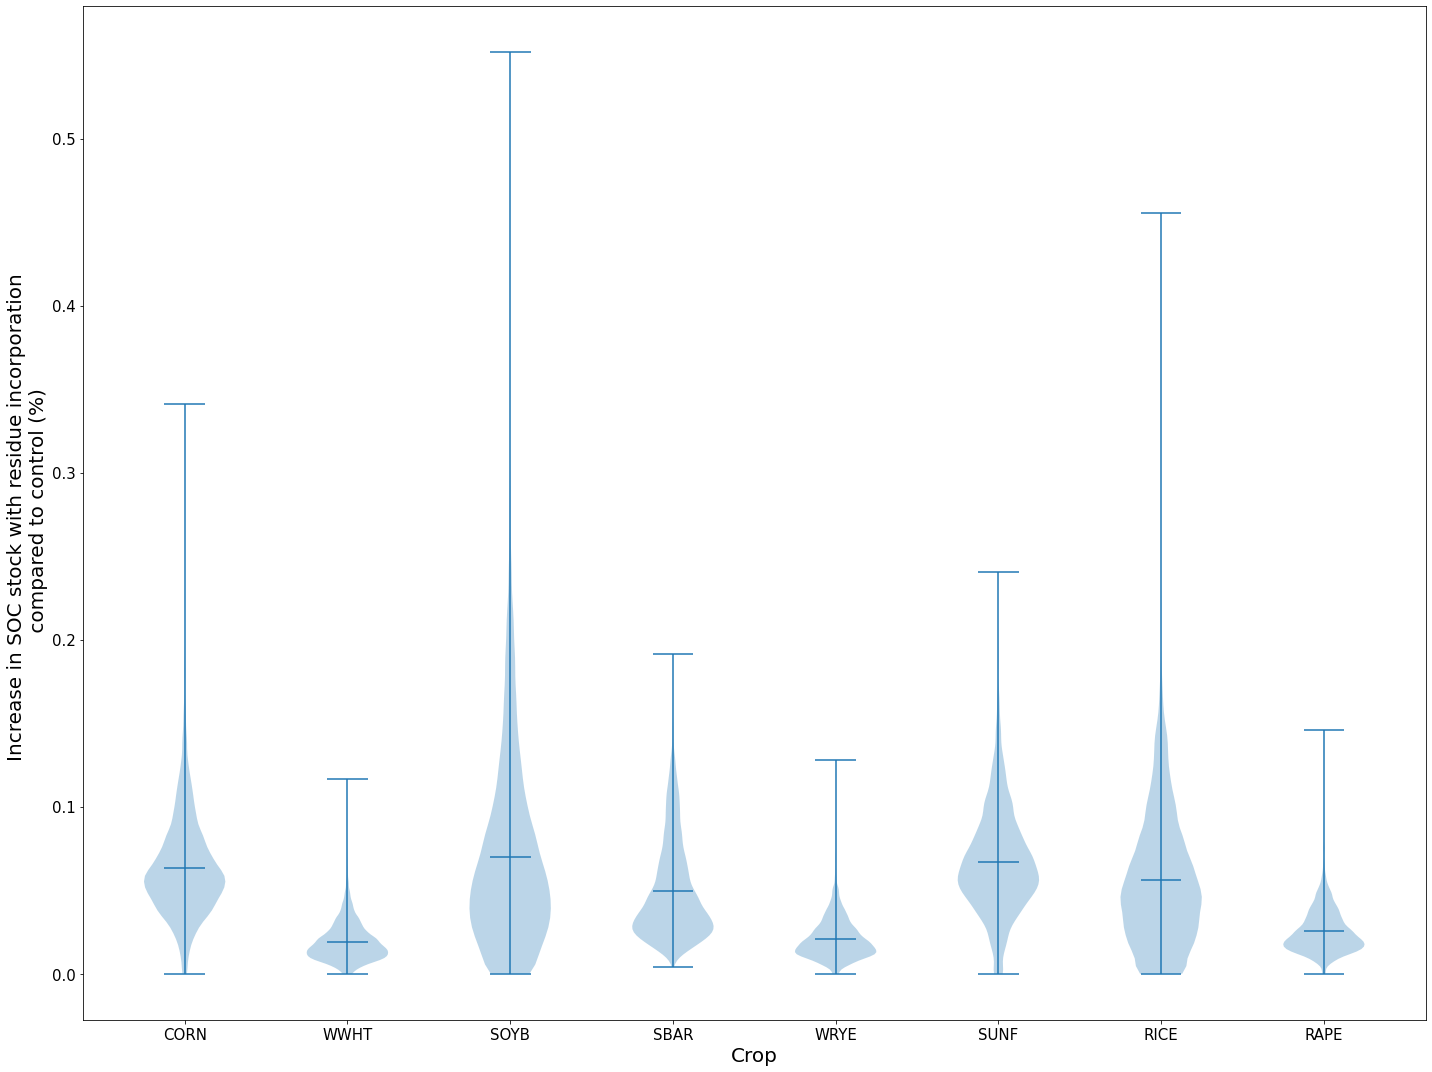

In [35]:
plt.figure(figsize = (20,15))
# plt.title("ABSOLUTE CONTROL", fontsize = 20)

plt.violinplot(SOC_inc_list, showmeans = True)
plt.xticks(ticks = np.arange(1,9), labels = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE'], fontsize = 15)
plt.xlabel("Crop", fontsize = 20)

# plt.violinplot([BAU_SOC_inc, N50_SOC_inc, N100_SOC_inc, N250_SOC_inc], showmeans = True)
# plt.xticks(ticks = np.arange(1,5), labels = ['BAU', 'N50', 'N100', 'N250'], fontsize = 15)
# plt.xlabel("Maximum N addition", fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel("Increase in SOC stock with residue incorporation \n compared to control (%)", fontsize = 20)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//SOC_inc_by_crop_META.jpg")
# plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//SOC_inc_by_N_META.jpg")


In [16]:
#### AVERAGE OVER CROP AND N TREATMENT THE TREATMENT EFFECT OF RESIDUES
treat_avs = []
for t in SOC_change_list: 
    res = t[['SimUID', 'SCEN', 'inc_SOC', 'SOC_inc_over_control']].groupby(['SimUID', 'SCEN']).mean().reset_index()
    treat_avs.append(res)
treat_avs_across_crop = pd.concat(treat_avs).groupby(['SimUID', 'SCEN']).mean().reset_index()

In [17]:
# get site info to plot against treatment effect 
site_info = predicted_list[0].groupby("SimUID").mean().reset_index()[['SimUID', 'OC_TOP', 'SAND_PROFILE', 'SILT_PROFILE', 'CLAY_PROFILE',
       'BD_PROFILE', 'BS_PROFILE', 'CEC_PROFILE', 'SOB_PROFILE', 'PH_PROFILE',
       'VS_PROFILE', 'KS_PROFILE', 'WP_PROFILE', 'FWC_PROFILE', 'PETsumGS',
       'PETavGS', 'PETskGS', 'PRCPsumGS', 'PRCPavGS', 'PRCPskGS', 'RADsumGS',
       'RADavGS', 'RADskGS', 'TMEANavGS', 'TMEANskGS', 'VPDsumGS', 'VPDavGS',
       'VPDskGS', 'CMDsumGS', 'CMDavGS', 'CMDskGS', 'FNO3_AGG', 'RSDC_AGG',
       'RSDCa', 'OCPD_JAN', 'TEXTURE']]

In [18]:
treat_avs_full = treat_avs_across_crop.merge(site_info, how = "left", on = ["SimUID"])
treat_avs_BAU = treat_avs_full[treat_avs_full.SCEN.str.contains("BAU")]
treat_avs_N50 = treat_avs_full[treat_avs_full.SCEN.str.contains("N50")]
treat_avs_N100 = treat_avs_full[treat_avs_full.SCEN.str.contains("N100")]
treat_avs_N250 = treat_avs_full[treat_avs_full.SCEN.str.contains("N250")]

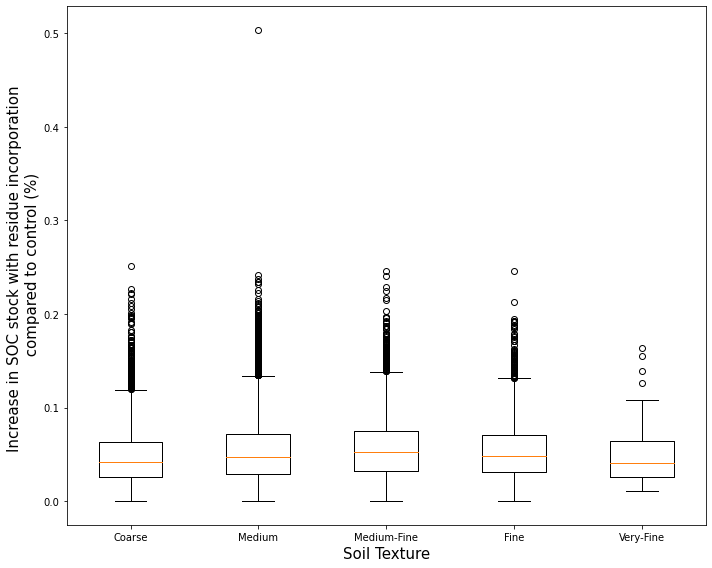

In [39]:
#### box plots treatment effect texture
df = treat_avs_full
fig = plt.figure(figsize = (10,8))
l = ['Coarse', 'Medium', 'Medium-Fine', 'Fine', 'Very-Fine']
plt.boxplot([df[df.TEXTURE == 1].SOC_inc_over_control, df[df.TEXTURE == 2].SOC_inc_over_control, df[df.TEXTURE == 3].SOC_inc_over_control, df[df.TEXTURE == 4].SOC_inc_over_control, df[df.TEXTURE == 5].SOC_inc_over_control], labels = l)
plt.ylabel("Increase in SOC stock with residue incorporation \n compared to control (%)", fontsize = 15)
# plt.ylim(0, .06)
plt.xlabel("Soil Texture", fontsize = 15)
plt.tight_layout()
# plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//conv_eff_v_tex_META.jpg")

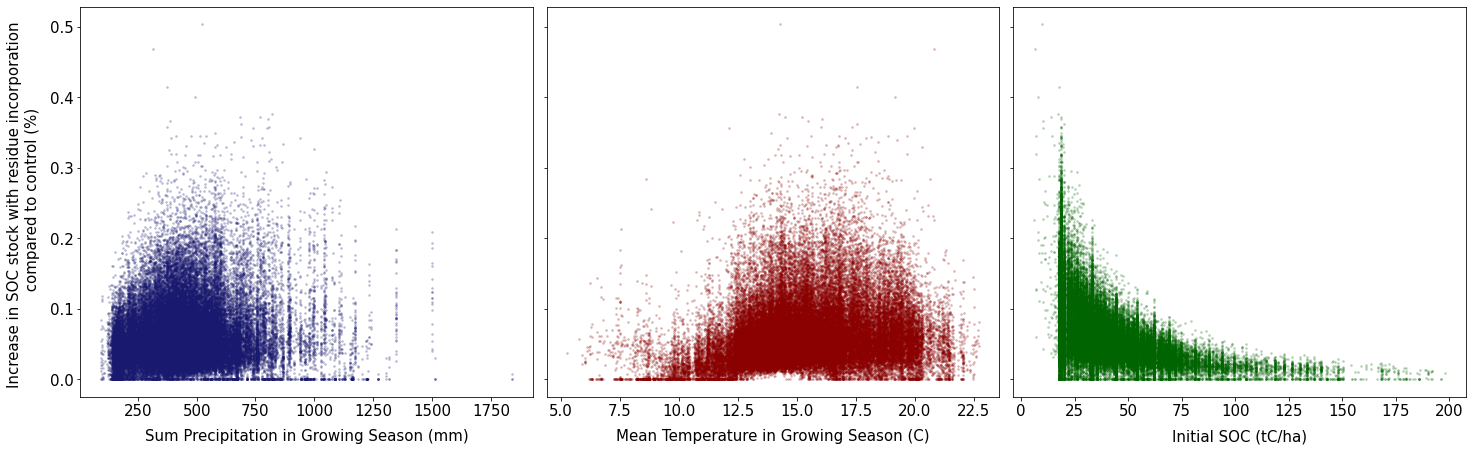

In [95]:
#### CONV EFF RELATIONSHIP PLOTS
df = treat_avs_full
from sklearn.metrics import r2_score
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21,7), sharex = False, sharey = True)
ax[0].scatter(df.PRCPsumGS, df.SOC_inc_over_control, s = 3, alpha = .2, color = 'midnightblue')
# z = np.polyfit(df.PRCPsumGS, df.SOC_inc_over_control, 1)
# slope = z[0]
# intercept = z[1]
# p = np.poly1d(z)
# ax[0].set_ylim(0,.06)
# ax[0].plot(np.arange(min(ALL_DF.PRCPsumGS), max(ALL_DF.PRCPsumGS), 10), p(np.arange(min(ALL_DF.PRCPsumGS), max(ALL_DF.PRCPsumGS), 10)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# ax[0].text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(ALL_DF.conv_eff, p(ALL_DF.PRCPsumGS))), transform=ax[0].transAxes, fontsize = 20)
ax[0].set_xlabel("Sum Precipitation in Growing Season (mm)", fontsize = 15, labelpad = 10)
ax[0].set_ylabel("Increase in SOC stock with residue incorporation \n compared to control (%)", fontsize = 15, labelpad = 10)
ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)

ax[1].scatter(df.TMEANavGS, df.SOC_inc_over_control, s = 3, alpha = .2, color = 'darkred')
# z = np.polyfit(df.TMEANavGS, df.SOC_inc_over_control, 1)
# slope = z[0]
# intercept = z[1]
# p = np.poly1d(z)
# ax[1].set_ylim(0,.06)
# ax[1].plot(np.arange(min(ALL_DF.TMEANavGS), max(ALL_DF.TMEANavGS), .5), p(np.arange(min(ALL_DF.TMEANavGS), max(ALL_DF.TMEANavGS), .5)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# ax[1].text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(ALL_DF.conv_eff, p(ALL_DF.TMEANavGS))), transform=ax[1].transAxes, fontsize = 20)
ax[1].set_xlabel("Mean Temperature in Growing Season (C)", fontsize = 15, labelpad = 10)
ax[1].tick_params(axis='x', which='major', labelsize=15)

ax[2].scatter(df.OCPD_JAN, df.SOC_inc_over_control, s = 3, alpha = .2, color = 'darkgreen')
# z = np.polyfit(df.OCPD_JAN, df.SOC_inc_over_control, 1)
# slope = z[0]
# intercept = z[1]
# p = np.poly1d(z)
# ax[2].set_ylim(0,.06)
# ax[2].plot(np.arange(min(ALL_DF.OCPD_JAN), max(ALL_DF.OCPD_JAN), 1), p(np.arange(min(ALL_DF.OCPD_JAN), max(ALL_DF.OCPD_JAN), 1)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# ax[2].text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(ALL_DF.conv_eff, p(ALL_DF.OCPD_JAN))), transform=ax[2].transAxes, fontsize = 20)
ax[2].set_xlabel("Initial SOC (tC/ha)", fontsize = 15, labelpad = 10)
ax[2].tick_params(axis='x', which='major', labelsize=15)

plt.tight_layout(rect=[0.02, 0.04, 1, 0.95])
# plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//conv_eff_v_ALL_META.jpg")


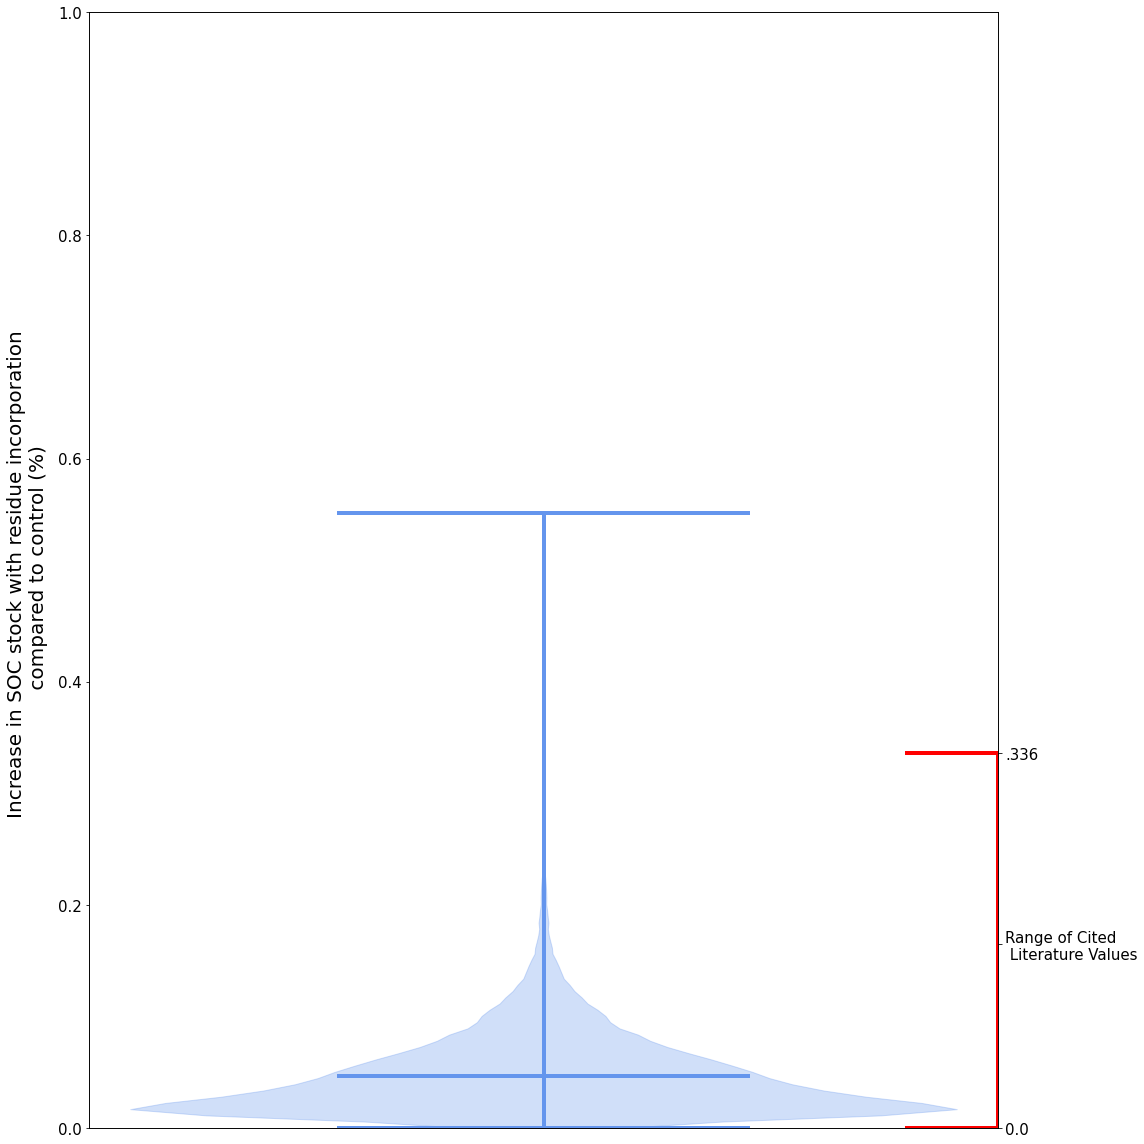

In [40]:
#### VIOLIN PLOT OF ALL RESIDUE TREATMENT EFFECTS 

# hlines = [.143, .197, .295, .052, .044, .07, .14, .12, .21, .3, .19, .128, .055, .11, .336, .06, .08, .07, .288, .251, .077]
# hline_labels = ['Frankinet et al., 1993', 'Kick & Poletschny, 1980', 'Thomsen, 1993', 'Powlson et al., 1987', 'Powlson et al., 1987', 'Sanden et al., 2018; Lehtinen et al., 2014', 'Abbas et al., 2020', 'Thomsen et al., 2004', 'Thomsen et al., 2004', 'Thomsen et al., 2004', 'Triberti et al., 2008', 'Du et al., 2010', 'Dikgwatlhe et al., 2014']
hlines = [0, .336]
hline_labels = ["Minimum", "Maximum"]
fig, ax = plt.subplots(figsize = (16,16))
vp = ax.violinplot(SOC_inc_all_c_all_N, widths = .7, showmeans = True)
ax.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False)
ax.set_ylim(0,1)
ax.tick_params(axis = 'y', labelsize = 15)
vp['bodies'][0].set_color('cornflowerblue')
vp['bodies'][0].set_alpha(.3)
# max_= vp['cmaxes'][0]
# min_ = vp['cmaxes'][0]
# mean = vp['cmeans'][0]
# bar = vp['cbars'][0]
for partname in ('cbars','cmins','cmaxes','cmeans'):
    piece = vp[partname]
    piece.set_edgecolor('cornflowerblue')
    piece.set_linewidth(4)

ax2 = ax.twinx()
ax2.set_ylim(0,1)
for h in hlines: 
    ax2.axhline(h, xmin = .9, xmax = 1, color = 'red', linewidth = 4)
ax2.set_yticks([0, .165, .336])
ax2.set_yticklabels(['0.0', "Range of Cited \n Literature Values", '.336'])
ax2.tick_params(axis = 'y', labelsize = 15)
ax2.axvline(ax2.get_xlim()[1], 0, .336, color = 'red', linewidth = 4)

ax.set_ylabel("Increase in SOC stock with residue incorporation \n compared to control (%)", fontsize = 20, labelpad = 10)
# plt.title("Increase in SOC stock - EPIC-IIASA META values vs. Cited Literature", fontsize = 20)
fig.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//SOC_inc_EPIC_v_literature_META.jpg")

## Micro Validation

In [2]:
loc_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt").drop(["POINTID", "LCF3"], axis = 1)
loc_micro = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//micro_points.csv").drop(["Latitude", "Longitude"], axis = 1)

In [3]:
# get annual climate data
clim = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUID_clim.csv")
clim_grouped = clim.groupby("SimUID").mean()[['AGG_PRCP', 'MEAN_TMX', 'MEAN_TMN']].reset_index()
clim_grouped.MEAN_TMX = (clim.JAN_TMX + clim.FEB_TMX + clim.MAR_TMX + clim.APR_TMX + clim.MAY_TMX + clim.JUN_TMX + clim.JUL_TMX + clim.AUG_TMX + clim.SEP_TMX + clim.OCT_TMX + clim.NOV_TMX + clim.DEC_TMX)/12
clim_grouped.MEAN_TMN = (clim.JAN_TMN + clim.FEB_TMN + clim.MAR_TMN + clim.APR_TMN + clim.MAY_TMN + clim.JUN_TMN + clim.JUL_TMN + clim.AUG_TMN + clim.SEP_TMN + clim.OCT_TMN + clim.NOV_TMN + clim.DEC_TMN)/12
clim_grouped['MEAN_TEMP'] = (clim_grouped.MEAN_TMX + clim_grouped.MEAN_TMN) / 2


In [19]:
# GET ALL NEIGHBORS WITHIN A DISTANCE  
# distance in m
d = 50000
point_tree = spatial.cKDTree(loc_df[['X','Y']])
indices = point_tree.query_ball_point(loc_micro, d)

# get SimU Ids for nearest neighbors
CR_list = []
for i in range(4):
    CR_list.append(loc_df.iloc[indices[i]].SimUID.unique().tolist())
CR_ids = [item for sublist in CR_list for item in sublist]
                   
IT_ids = loc_df.iloc[indices[4]].SimUID.unique().tolist()
FN_ids = loc_df.iloc[indices[5]].SimUID.unique().tolist()
IR_ids = loc_df.iloc[indices[6]].SimUID.unique().tolist()

# for each experiment, pull records on k closest simU 
CR = treat_avs_across_crop[treat_avs_across_crop.SimUID.isin(CR_ids)]
IT = treat_avs_across_crop[treat_avs_across_crop.SimUID.isin(IT_ids)]
FN = treat_avs_across_crop[treat_avs_across_crop.SimUID.isin(FN_ids)]
IR = treat_avs_across_crop[treat_avs_across_crop.SimUID.isin(IR_ids)]

In [20]:
# GET SITE INFORMATION TO COPMARE TO EXPERIMENTAL SITE INFO
ref_df = all_treat_list[0].merge(clim_grouped, how = 'left', on = "SimUID")
# for each experiment, pull records on k closest simU 
CR_site = ref_df[ref_df.SimUID.isin(CR_ids)][['SAND_PROFILE',
       'SILT_PROFILE', 'CLAY_PROFILE', 'BD_PROFILE', 'OCPD_JAN', 'TEXTURE', 'AGG_PRCP','MEAN_TEMP']]
IT_site = ref_df[ref_df.SimUID.isin(IT_ids)][['SAND_PROFILE',
       'SILT_PROFILE', 'CLAY_PROFILE', 'BD_PROFILE', 'OCPD_JAN', 'TEXTURE', 'AGG_PRCP','MEAN_TEMP']]
FN_site = ref_df[ref_df.SimUID.isin(FN_ids)][['SAND_PROFILE',
       'SILT_PROFILE', 'CLAY_PROFILE', 'BD_PROFILE', 'OCPD_JAN', 'TEXTURE', 'AGG_PRCP','MEAN_TEMP']]
IR_site = ref_df[ref_df.SimUID.isin(IR_ids)][['SAND_PROFILE',
       'SILT_PROFILE', 'CLAY_PROFILE', 'BD_PROFILE', 'OCPD_JAN', 'TEXTURE', 'AGG_PRCP','MEAN_TEMP']]

In [21]:
IR.SOC_inc_over_control

8768    0.029416
8775    0.028340
8783    0.012925
8806    0.032065
Name: SOC_inc_over_control, dtype: float64

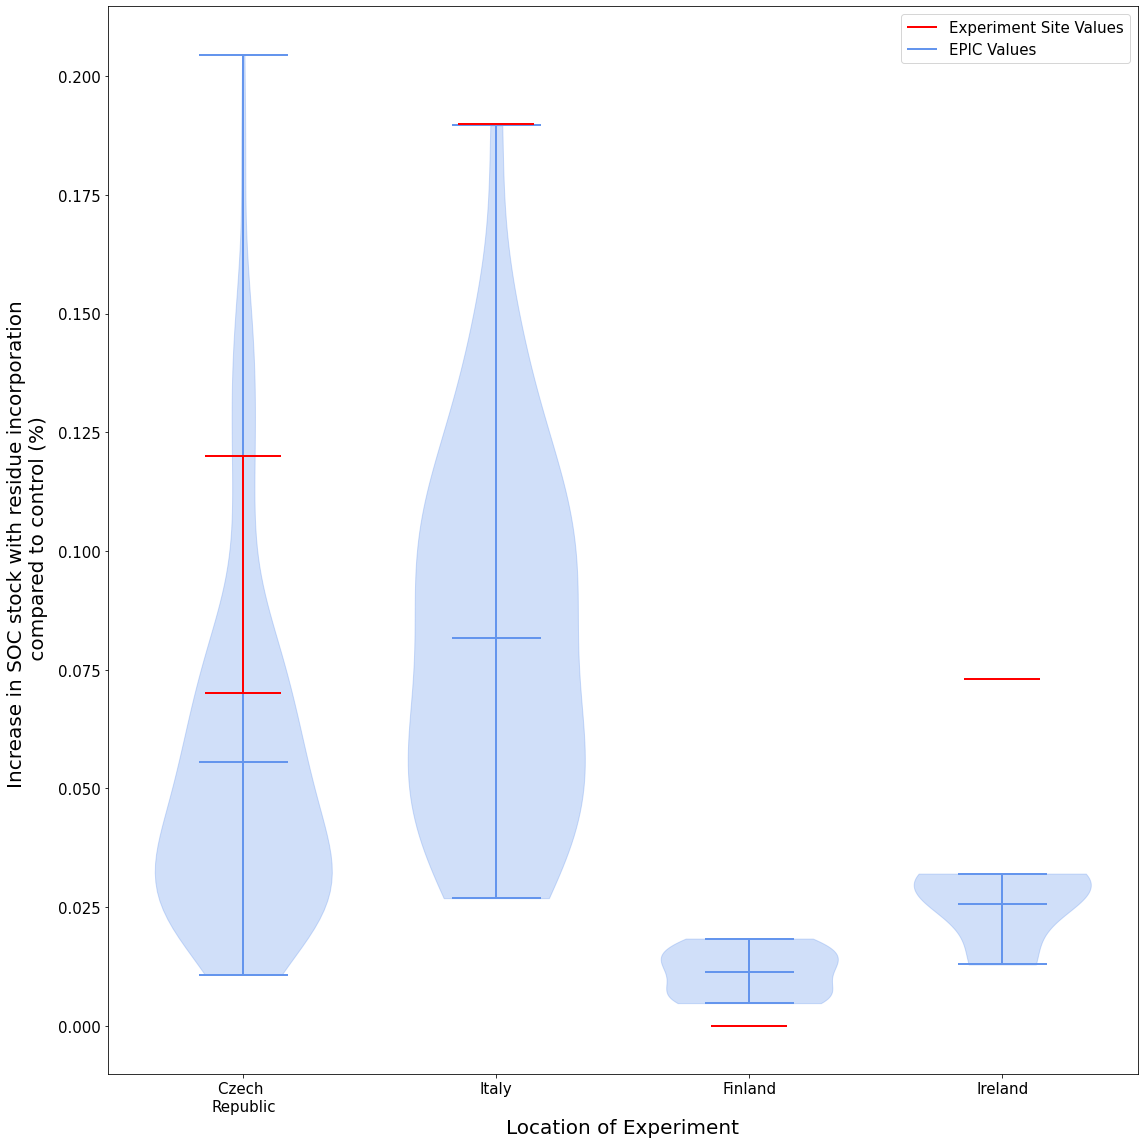

In [48]:
#### VIOLIN PLOT OF ALL RESIDUE TREATMENT EFFECTS 
fig, ax = plt.subplots(figsize = (16,16))

# SOC
# plt.title("Increase in SOC stock - EPIC-IIASA META values within 50km of Experimental Sites vs. Long Term Experiments", fontsize = 20)
vp = ax.violinplot([CR.SOC_inc_over_control, IT.SOC_inc_over_control, FN.SOC_inc_over_control, IR.SOC_inc_over_control], widths = .7, showmeans = True)
ax.set_ylabel("Increase in SOC stock with residue incorporation \n compared to control (%)", fontsize = 20, labelpad = 10)
# lines for increase in SOC stock 
ax.hlines([.07, .12, .19, 0, .073], [.85, .85, 1.85, 2.85, 3.85], [1.15, 1.15, 2.15, 3.15, 4.15], colors = 'red', linewidth = 2, label = "Experiment Site Values")
ax.vlines([1], [.07], [.12], colors = "red", linewidth = 2) 

ax.set_xticks(ticks = np.arange(1,5), labels = ['Czech \nRepublic', 'Italy', 'Finland', 'Ireland'], fontsize = 15)
ax.set_xlabel("Location of Experiment", fontsize = 20)
ax.hlines([], [], [], color = 'cornflowerblue', linewidth = 2, label = "EPIC Values")
ax.tick_params(axis = 'y', labelsize = 15)
ax.legend(fontsize = 15)

# change colors
for b in vp['bodies']:
    b.set_color('cornflowerblue')
    b.set_alpha(.3)

for partname in ('cbars','cmins','cmaxes','cmeans'):
    piece = vp[partname]
    piece.set_edgecolor('cornflowerblue')
    piece.set_linewidth(2)
fig.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//micro_50km_violin_META.jpg")



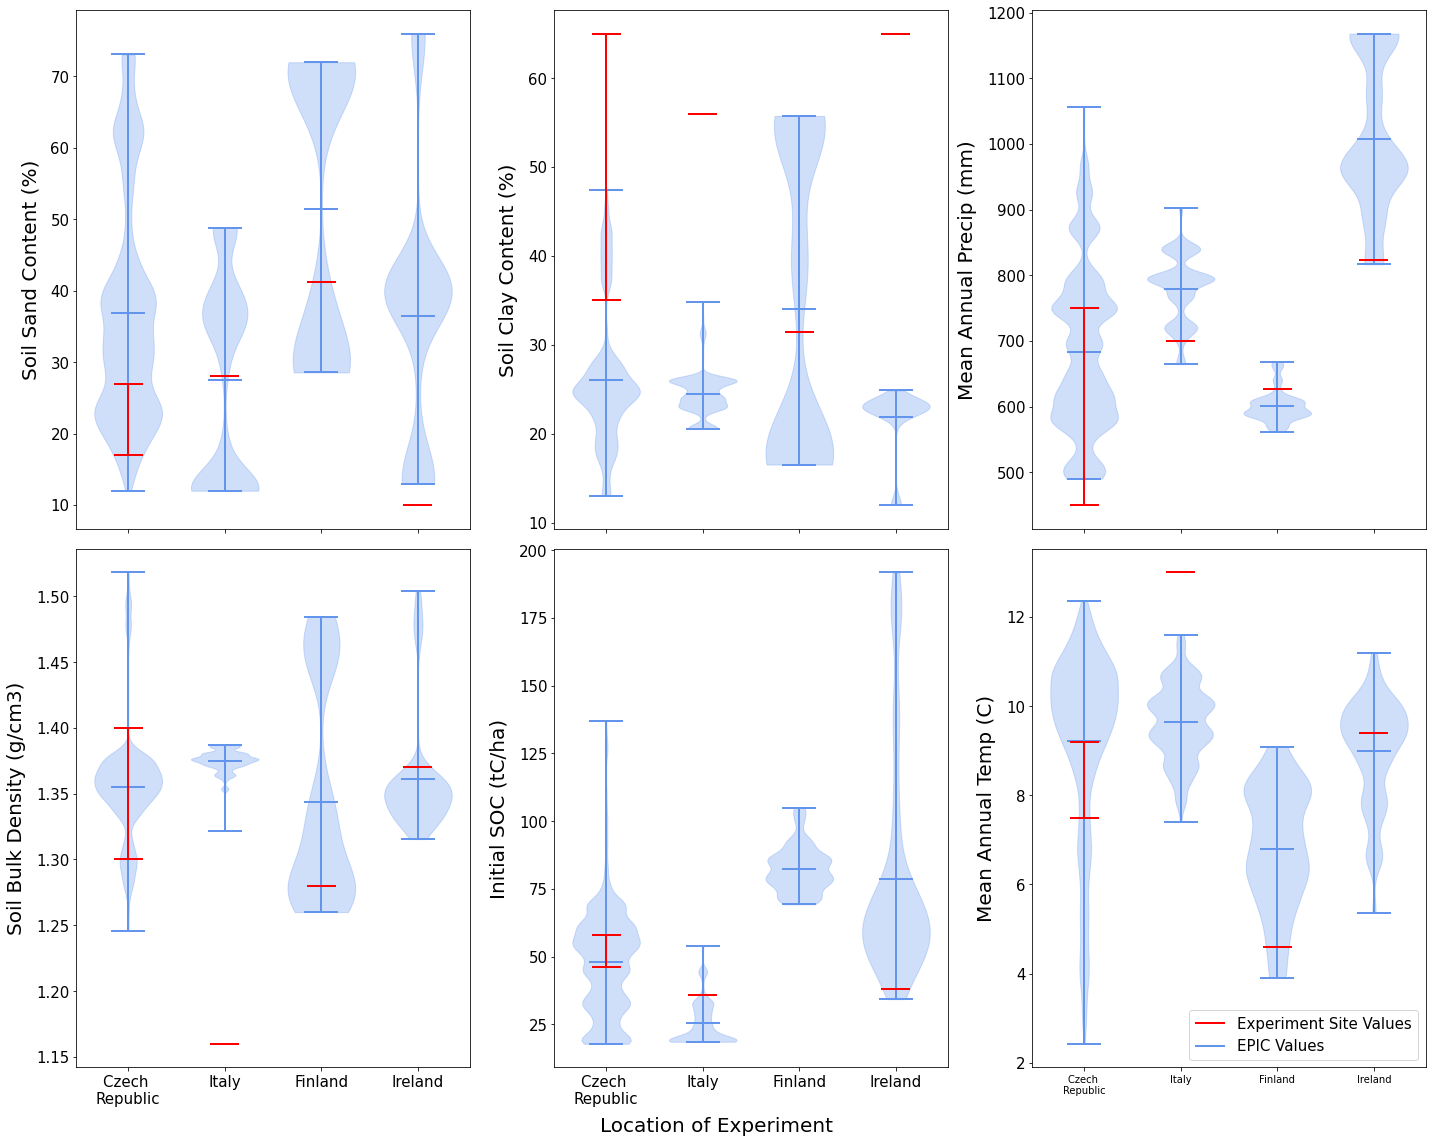

In [49]:
#### VIOLIN PLOT OF ALL RESIDUE TREATMENT EFFECTS 
fig, ax = plt.subplots(2,3, figsize = (20,16), sharex = True)

# Others
# plt.suptitle("EPIC-IIASA values within 50km of Experimental Sites vs. Long Term Experiments", fontsize = 20)

# Violin Plots
vp1 = ax[0][0].violinplot([CR_site.SAND_PROFILE, IT_site.SAND_PROFILE, FN_site.SAND_PROFILE, IR_site.SAND_PROFILE], widths = .7, showmeans = True)
vp2 = ax[0][1].violinplot([CR_site.CLAY_PROFILE, IT_site.CLAY_PROFILE, FN_site.CLAY_PROFILE, IR_site.CLAY_PROFILE], widths = .7, showmeans = True)
vp3 = ax[1][0].violinplot([CR_site.BD_PROFILE, IT_site.BD_PROFILE, FN_site.BD_PROFILE, IR_site.BD_PROFILE], widths = .7, showmeans = True)
vp4 = ax[1][1].violinplot([CR_site.OCPD_JAN, IT_site.OCPD_JAN, FN_site.OCPD_JAN, IR_site.OCPD_JAN], widths = .7, showmeans = True)
vp5 = ax[0][2].violinplot([CR_site.AGG_PRCP, IT_site.AGG_PRCP, FN_site.AGG_PRCP, IR_site.AGG_PRCP], widths = .7, showmeans = True)
vp6 = ax[1][2].violinplot([CR_site.MEAN_TEMP, IT_site.MEAN_TEMP, FN_site.MEAN_TEMP, IR_site.MEAN_TEMP], widths = .7, showmeans = True)

# Labels
ax[0][0].set_ylabel("Soil Sand Content (%)", fontsize = 20, labelpad = 10)
ax[0][0].tick_params(axis = 'y', labelsize = 15)
ax[0][1].set_ylabel("Soil Clay Content (%)", fontsize = 20, labelpad = 10)
ax[0][1].tick_params(axis = 'y', labelsize = 15)
ax[1][0].set_ylabel("Soil Bulk Density (g/cm3)", fontsize = 20, labelpad = 10)
ax[1][0].tick_params(axis = 'y', labelsize = 15)
ax[1][1].set_ylabel("Initial SOC (tC/ha)", fontsize = 20, labelpad = 10)
ax[1][1].tick_params(axis = 'y', labelsize = 15)
ax[0][2].set_ylabel("Mean Annual Precip (mm)", fontsize = 20, labelpad = 10)
ax[0][2].tick_params(axis = 'y', labelsize = 15)
ax[1][2].set_ylabel("Mean Annual Temp (C)", fontsize = 20, labelpad = 10)
ax[1][2].tick_params(axis = 'y', labelsize = 15)

    
# lines for clay content 
ax[0][0].hlines([17, 27, 28, 41.2, 10], [.85, .85, 1.85, 2.85, 3.85], [1.15, 1.15, 2.15, 3.15, 4.15], colors = 'red', linewidth = 2, label = "Experiment Site Values")
ax[0][0].vlines([1], [17], [27], colors = "red", linewidth = 2) 

# lines for sand content 
ax[0][1].hlines([35, 65, 56, 31.5, 65], [.85, .85, 1.85, 2.85, 3.85], [1.15, 1.15, 2.15, 3.15, 4.15], colors = 'red', linewidth = 2, label = "Experiment Site Values")
ax[0][1].vlines([1], [35], [65], colors = "red", linewidth = 2) 

# lines for bulk density 
ax[1][0].hlines([1.3, 1.4, 1.16, 1.28, 1.37], [.85, .85, 1.85, 2.85, 3.85], [1.15, 1.15, 2.15, 3.15, 4.15], colors = 'red', linewidth = 2, label = "Experiment Site Values")
ax[1][0].vlines([1], [1.3], [1.4], colors = "red", linewidth = 2) 

# lines for initial SOC 
ax[1][1].hlines([46, 58, 35.82, 38], [.85, .85, 1.85, 3.85], [1.15, 1.15, 2.15, 4.15], colors = 'red', linewidth = 2, label = "Experiment Site Values")
ax[1][1].vlines([1], [46], [58], colors = "red", linewidth = 2)

# lines for annual precip 
ax[0][2].hlines([450, 750, 700, 627, 824], [.85, .85, 1.85, 2.85, 3.85], [1.15, 1.15, 2.15, 3.15, 4.15], colors = 'red', linewidth = 2, label = "Experiment Site Values")
ax[0][2].vlines([1], [450], [750], colors = "red", linewidth = 2)

# lines for annual precip 
ax[1][2].hlines([7.5, 9.2, 13, 4.6, 9.4], [.85, .85, 1.85, 2.85, 3.85], [1.15, 1.15, 2.15, 3.15, 4.15], colors = 'red', linewidth = 2, label = "Experiment Site Values")
ax[1][2].vlines([1], [7.5], [9.2], colors = "red", linewidth = 2)

# Everything else - general 
ax[1][0].set_xticks(ticks = np.arange(1,5), labels = ['Czech \nRepublic', 'Italy', 'Finland', 'Ireland'], fontsize = 15)
ax[1][1].set_xticks(ticks = np.arange(1,5), labels = ['Czech \nRepublic', 'Italy', 'Finland', 'Ireland'], fontsize = 15)
ax[1][2].hlines([], [], [], color = 'cornflowerblue', linewidth = 2, label = "EPIC Values")
ax[1][2].legend(fontsize = 15, loc = 'lower right')

fig.supxlabel("Location of Experiment", fontsize = 20)

# change colors
for vp in [vp1, vp2, vp3, vp4, vp5, vp6]:
    for b in vp['bodies']:
        b.set_color('cornflowerblue')
        b.set_alpha(.3)

    for partname in ('cbars','cmins','cmaxes','cmeans'):
        piece = vp[partname]
        piece.set_edgecolor('cornflowerblue')
        piece.set_linewidth(2)
    
fig.tight_layout()
# plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//micro_50km_violin_SITE_PARAMS.jpg")



### C Conversion Efficiencies 

In [55]:
#### CALCULATE CONV EFFICIENCIES FOR EACH CROP 
## above ground - RSDCa, amount in 0-15cm = .75*RSDCa
## below ground - RW, amount in 0-15cm = .55*RW
for t in predicted_list: 
    t['conv_eff'] = t['predicted_mean_OCPD_change']/(((t['RSDCa']*.75)/1000)+(t['RW']*.55*.42))
    t['conv_eff'] = t['conv_eff'].where(t['conv_eff']>=0, other=0)
    t['conv_eff'] = t['conv_eff'].where(t['conv_eff']<=1, other=1)

In [56]:
BAU_list = []
N50_list = []
N100_list = []
N250_list = []
for df in predicted_list: 
    BAU_list.append(df[df.SCEN.str.contains('BAU')].conv_eff.tolist())
    N50_list.append(df[df.SCEN.str.contains('N50')].conv_eff.tolist())
    N100_list.append(df[df.SCEN.str.contains('N100')].conv_eff.tolist())
    N250_list.append(df[df.SCEN.str.contains('N250')].conv_eff.tolist())
BAU_c_conv = [item for sublist in BAU_list for item in sublist]
N50_c_conv = [item for sublist in N50_list for item in sublist]
N100_c_conv = [item for sublist in N100_list for item in sublist]
N250_c_conv = [item for sublist in N250_list for item in sublist]

In [57]:
#### CONV EFF LIST FOR EACH CROP 
conv_eff_list = [c.conv_eff.tolist() for c in predicted_list]  
# All CONV EFF for all crops and all N rates 
conv_eff_all_c_all_N = [item for sublist in conv_eff_list for item in sublist]

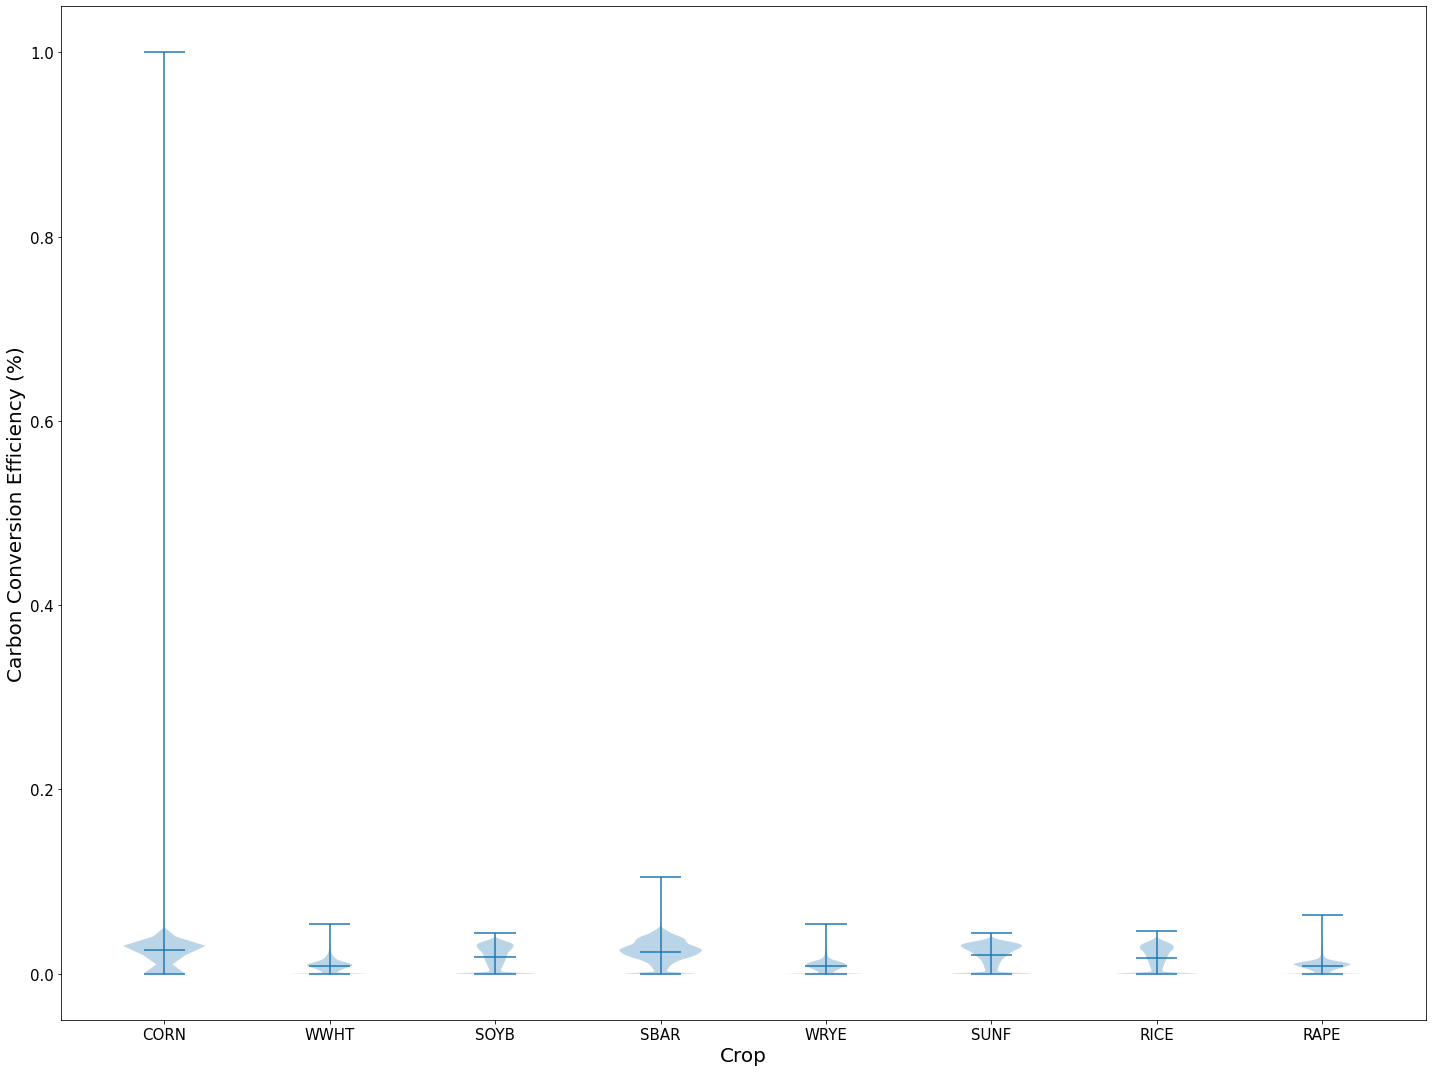

In [58]:
plt.figure(figsize = (20,15))
# plt.title("ABSOLUTE CONTROL", fontsize = 20)
# plt.violinplot([BAU_c_conv, N50_c_conv, N100_c_conv, N250_c_conv], showmeans = True)
# plt.xticks(ticks = np.arange(1,5), labels = ['BAU', 'N50', 'N100', 'N250'], fontsize = 15)
# plt.xlabel("Maximum N addition", fontsize = 20)

plt.violinplot(conv_eff_list, showmeans = True, showextrema = True)
plt.xticks(ticks = np.arange(1,9), labels = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE'], fontsize = 15)
plt.xlabel("Crop", fontsize = 20)

plt.yticks(fontsize = 15)
plt.ylabel("Carbon Conversion Efficiency (%)", fontsize = 20)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//C_conv_eff_by_crop.jpg")
# plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//C_conv_eff_by_N.jpg")


In [66]:
sum([v for v in conv_eff_all_c_all_N if v> .05])/len([v for v in conv_eff_all_c_all_N if v> .05])

0.06931078980445327

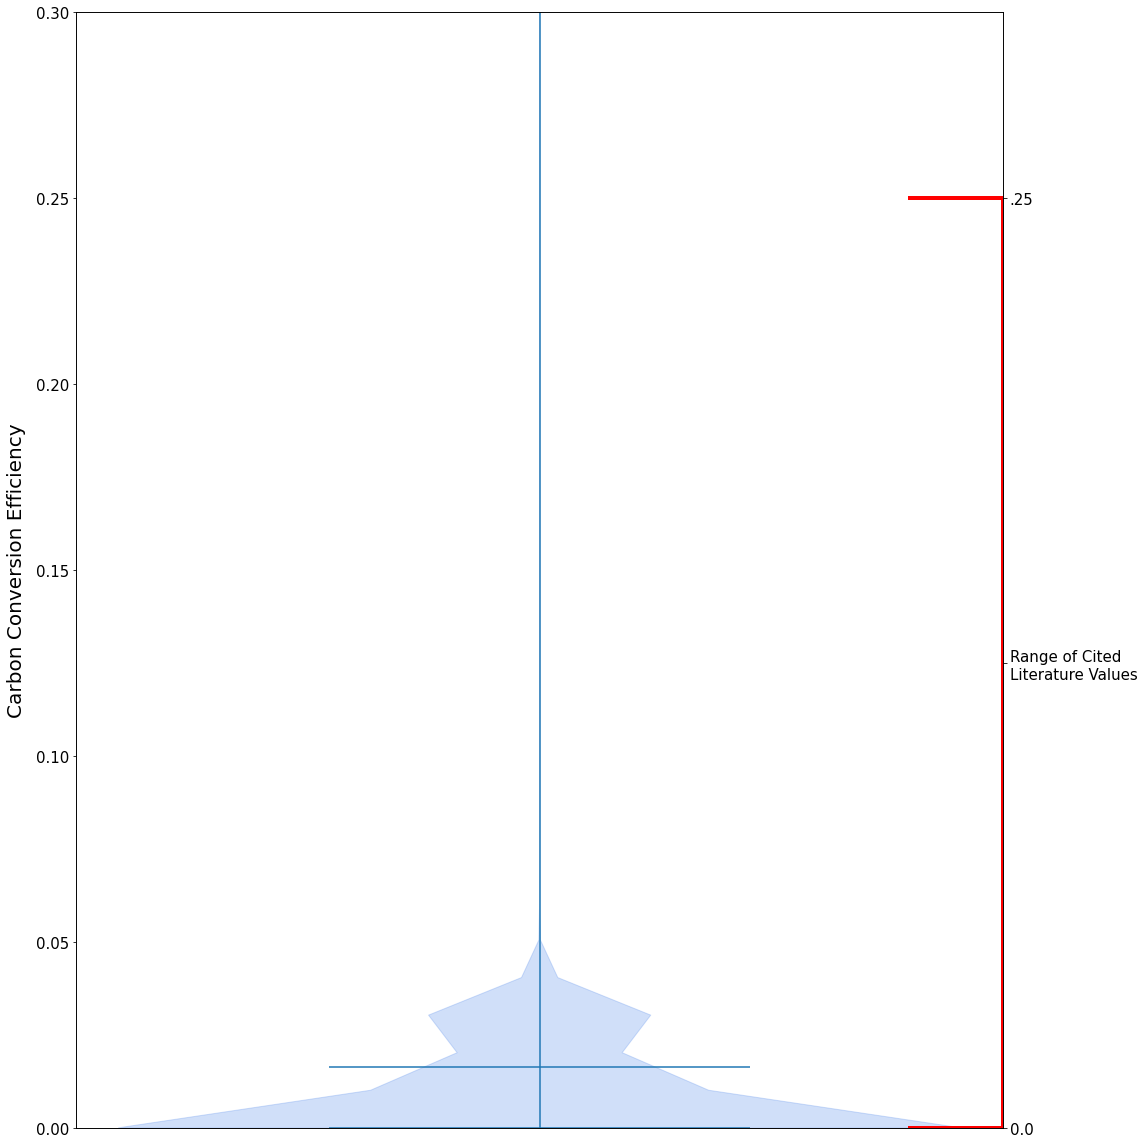

In [59]:
#### VIOLIN PLOT OF ALL C CONVERSION EFFICIENCIES 

# hlines = [.143, .197, .295, .052, .044, .07, .14, .12, .21, .3, .19, .128, .055, .11, .336, .06, .08, .07, .288, .251, .077]
# hline_labels = ['Frankinet et al., 1993', 'Kick & Poletschny, 1980', 'Thomsen, 1993', 'Powlson et al., 1987', 'Powlson et al., 1987', 'Sanden et al., 2018; Lehtinen et al., 2014', 'Abbas et al., 2020', 'Thomsen et al., 2004', 'Thomsen et al., 2004', 'Thomsen et al., 2004', 'Triberti et al., 2008', 'Du et al., 2010', 'Dikgwatlhe et al., 2014']
hlines = [0, .25]
hline_labels = ["Minimum", "Maximum"]
fig, ax = plt.subplots(figsize = (16,16))
vp = ax.violinplot(conv_eff_all_c_all_N, widths = .7, showmeans = True)
ax.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False)
ax.set_ylim(0,.3)
ax.tick_params(axis = 'y', labelsize = 15)
vp['bodies'][0].set_color('cornflowerblue')
vp['bodies'][0].set_alpha(.3)
# max_= vp['cmaxes'][0]
# min_ = vp['cmaxes'][0]
# mean = vp['cmeans'][0]
# bar = vp['cbars'][0]
# for partname in ('cbars','cmins','cmaxes','cmeans'):
#     piece = vp[partname]
#     piece.set_edgecolor('cornflowerblue')
#     piece.set_linewidth(4)

ax2 = ax.twinx()
ax2.set_ylim(0,.3)
for h in hlines: 
    ax2.axhline(h, xmin = .9, xmax = 1, color = 'red', linewidth = 4)
ax2.set_yticks([0, .125, .25])
ax2.set_yticklabels(['0.0', "Range of Cited \nLiterature Values", '.25'])
ax2.tick_params(axis = 'y', labelsize = 15)
ax2.axvline(ax2.get_xlim()[1], 0, .83333, color = 'red', linewidth = 4)

ax.set_ylabel("Carbon Conversion Efficiency", fontsize = 20, labelpad = 10)
# plt.title("C Conversion Efficiency - EPIC-IIASA META values vs. Cited Literature", fontsize = 20)
fig.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//c_conv_EPIC_v_literature_META.jpg")

In [60]:
#### AVERAGE OVER CROP AND N TREATMENT THE CONV EFFICIENCIES 
conv_avs = []
for t in predicted_list: 
    res = t[~t.SCEN.str.contains("R00")].groupby('SimUID').mean().reset_index()
    conv_avs.append(res)
conv_avs_across_crop = pd.concat(conv_avs).groupby('SimUID').mean().reset_index()
# bottom out the negative conv efficiencies to zero 
conv_avs_across_crop['conv_eff'] = conv_avs_across_crop['conv_eff'].where(conv_avs_across_crop['conv_eff']>=0, other=0)

In [61]:
ALL_DF = conv_avs_across_crop.merge(treat_avs_across_crop, how = 'left', on = 'SimUID')

/Users/taraippolito/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1215: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(


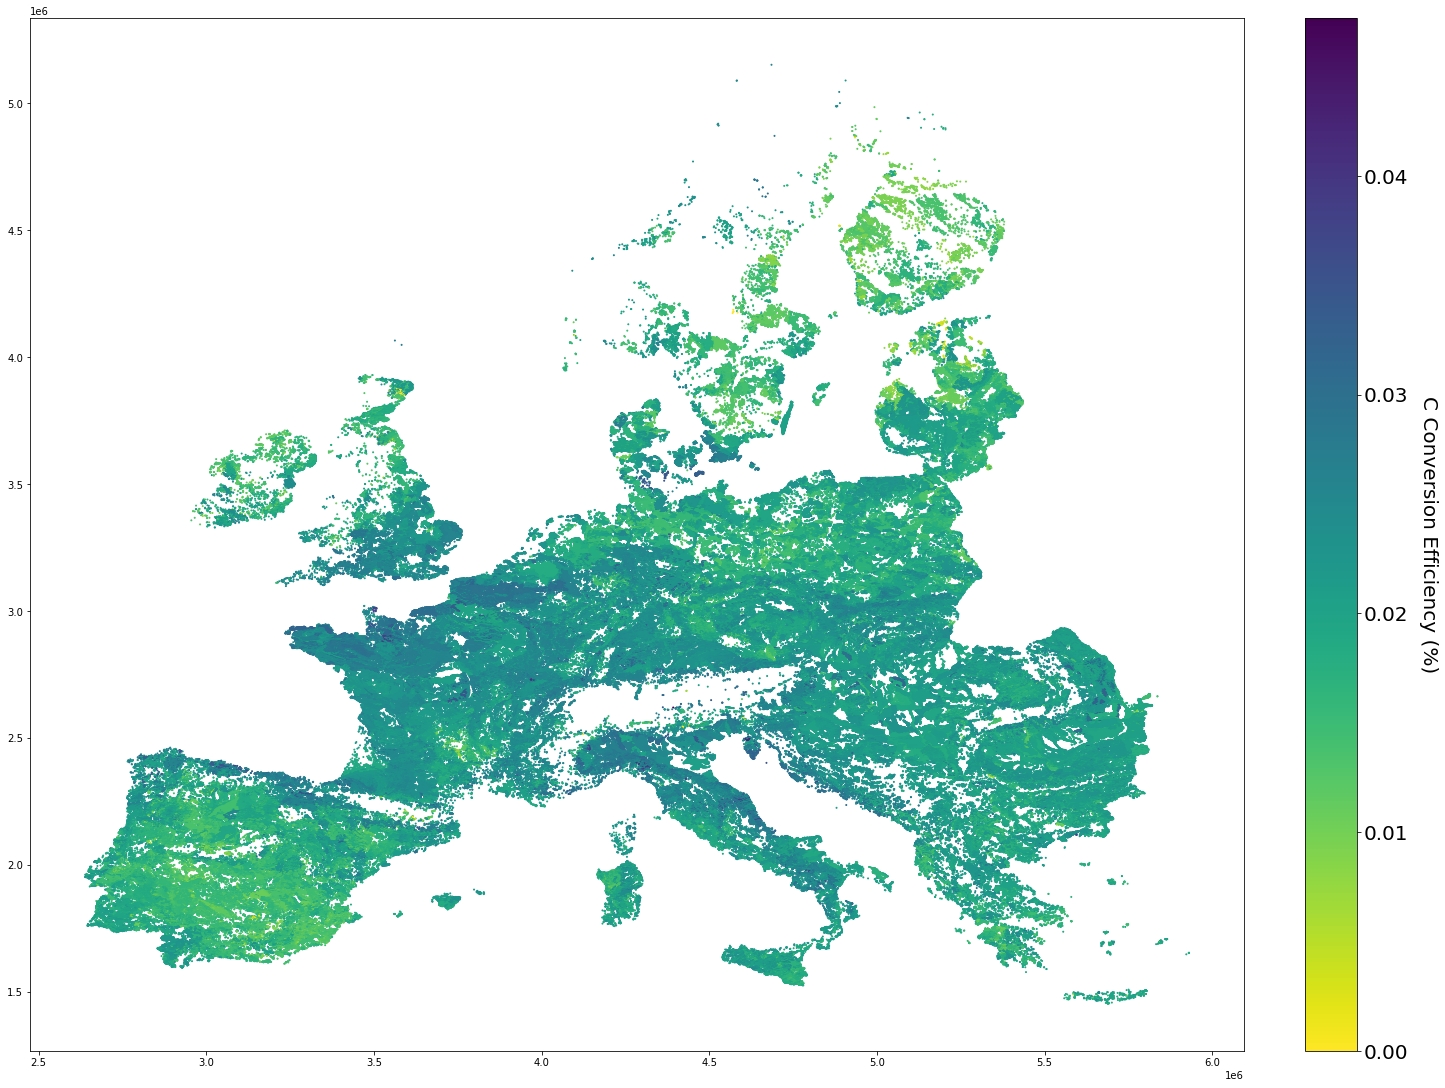

In [215]:
loc_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt")
pulled_pts = loc_df[loc_df.SimUID.isin(list(treat_avs_across_crop.SimUID.unique()))]
merged = pulled_pts.merge(ALL_DF, how = 'left', on = 'SimUID')
colm = cm.get_cmap('viridis_r')

#### MAP PLOTTING

var_to_plot = conv_avs_across_crop.conv_eff
fig = plt.figure(figsize = (20,15), constrained_layout=True)

# All positive values
colm = cm.get_cmap('viridis_r')
# plt.title(("C Conversion Efficiency Across Crops and N levels"), fontsize = 20)
plt.scatter(merged.X, merged.Y, s = 1, c = merged.conv_eff, cmap = colm, edgecolor = None, alpha = 1)
plt.grid(False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.set_label('C Conversion Efficiency (%)', rotation = 270, fontsize = 20, labelpad = 30)
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//conv_eff_avg_by_crop_N_META.jpg")

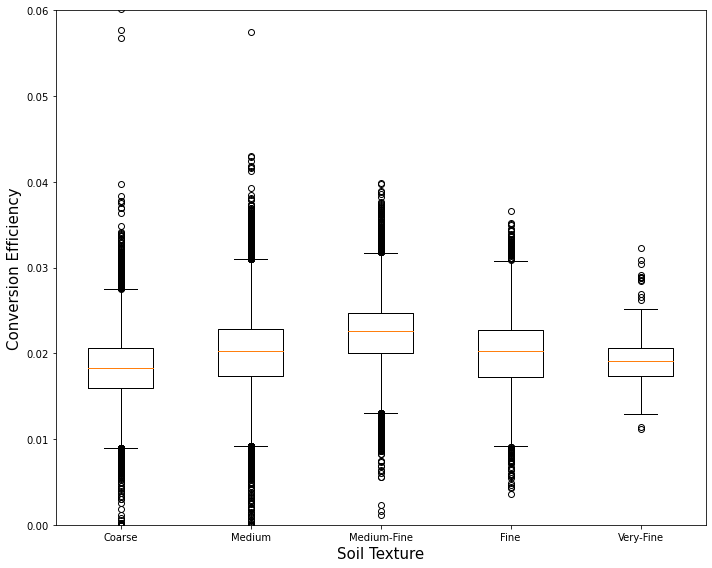

In [62]:
#### box plots conv eff texture
fig = plt.figure(figsize = (10,8))
l = ['Coarse', 'Medium', 'Medium-Fine', 'Fine', 'Very-Fine']
plt.boxplot([ALL_DF[ALL_DF.TEXTURE == 1].conv_eff, ALL_DF[ALL_DF.TEXTURE == 2].conv_eff, ALL_DF[ALL_DF.TEXTURE == 3].conv_eff, ALL_DF[ALL_DF.TEXTURE == 4].conv_eff, ALL_DF[ALL_DF.TEXTURE == 5].conv_eff], labels = l)
plt.ylabel("Conversion Efficiency", fontsize = 15)
plt.ylim(0, .06)
plt.xlabel("Soil Texture", fontsize = 15)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//conv_eff_v_tex_META.jpg")

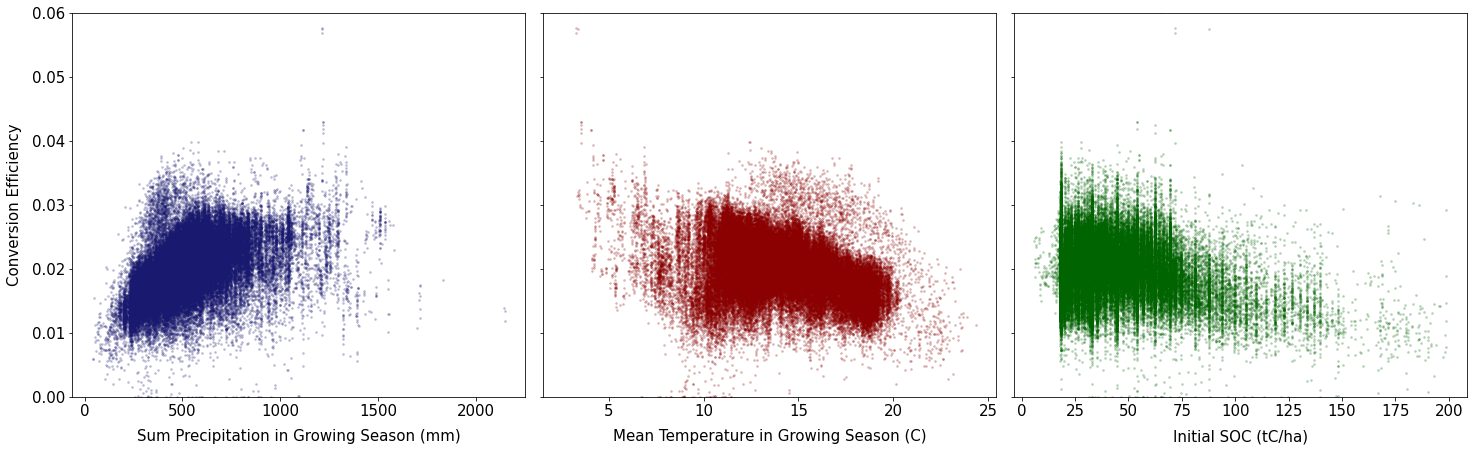

In [63]:
#### CONV EFF RELATIONSHIP PLOTS
from sklearn.metrics import r2_score
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21,7), sharex = False, sharey = True)
ax[0].scatter(ALL_DF.PRCPsumGS, ALL_DF.conv_eff, s = 3, alpha = .2, color = 'midnightblue')
z = np.polyfit(ALL_DF.PRCPsumGS, ALL_DF.conv_eff, 1)
slope = z[0]
intercept = z[1]
p = np.poly1d(z)
ax[0].set_ylim(0,.06)
# ax[0].plot(np.arange(min(ALL_DF.PRCPsumGS), max(ALL_DF.PRCPsumGS), 10), p(np.arange(min(ALL_DF.PRCPsumGS), max(ALL_DF.PRCPsumGS), 10)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# ax[0].text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(ALL_DF.conv_eff, p(ALL_DF.PRCPsumGS))), transform=ax[0].transAxes, fontsize = 20)
ax[0].set_xlabel("Sum Precipitation in Growing Season (mm)", fontsize = 15, labelpad = 10)
ax[0].set_ylabel("Conversion Efficiency", fontsize = 15, labelpad = 10)
ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)

ax[1].scatter(ALL_DF.TMEANavGS, ALL_DF.conv_eff, s = 3, alpha = .2, color = 'darkred')
z = np.polyfit(ALL_DF.TMEANavGS, ALL_DF.conv_eff, 1)
slope = z[0]
intercept = z[1]
p = np.poly1d(z)
ax[1].set_ylim(0,.06)
# ax[1].plot(np.arange(min(ALL_DF.TMEANavGS), max(ALL_DF.TMEANavGS), .5), p(np.arange(min(ALL_DF.TMEANavGS), max(ALL_DF.TMEANavGS), .5)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# ax[1].text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(ALL_DF.conv_eff, p(ALL_DF.TMEANavGS))), transform=ax[1].transAxes, fontsize = 20)
ax[1].set_xlabel("Mean Temperature in Growing Season (C)", fontsize = 15, labelpad = 10)
ax[1].tick_params(axis='x', which='major', labelsize=15)

ax[2].scatter(ALL_DF.OCPD_JAN, ALL_DF.conv_eff, s = 3, alpha = .2, color = 'darkgreen')
z = np.polyfit(ALL_DF.OCPD_JAN, ALL_DF.conv_eff, 1)
slope = z[0]
intercept = z[1]
p = np.poly1d(z)
ax[2].set_ylim(0,.06)
# ax[2].plot(np.arange(min(ALL_DF.OCPD_JAN), max(ALL_DF.OCPD_JAN), 1), p(np.arange(min(ALL_DF.OCPD_JAN), max(ALL_DF.OCPD_JAN), 1)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# ax[2].text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(ALL_DF.conv_eff, p(ALL_DF.OCPD_JAN))), transform=ax[2].transAxes, fontsize = 20)
ax[2].set_xlabel("Initial SOC (tC/ha)", fontsize = 15, labelpad = 10)
ax[2].tick_params(axis='x', which='major', labelsize=15)

plt.tight_layout(rect=[0.02, 0.04, 1, 0.95])
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//conv_eff_v_ALL_META.jpg")


## Effect of N when residues aren't incorporated 

/Users/taraippolito/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/numpy/lib/polynomial.py:659: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


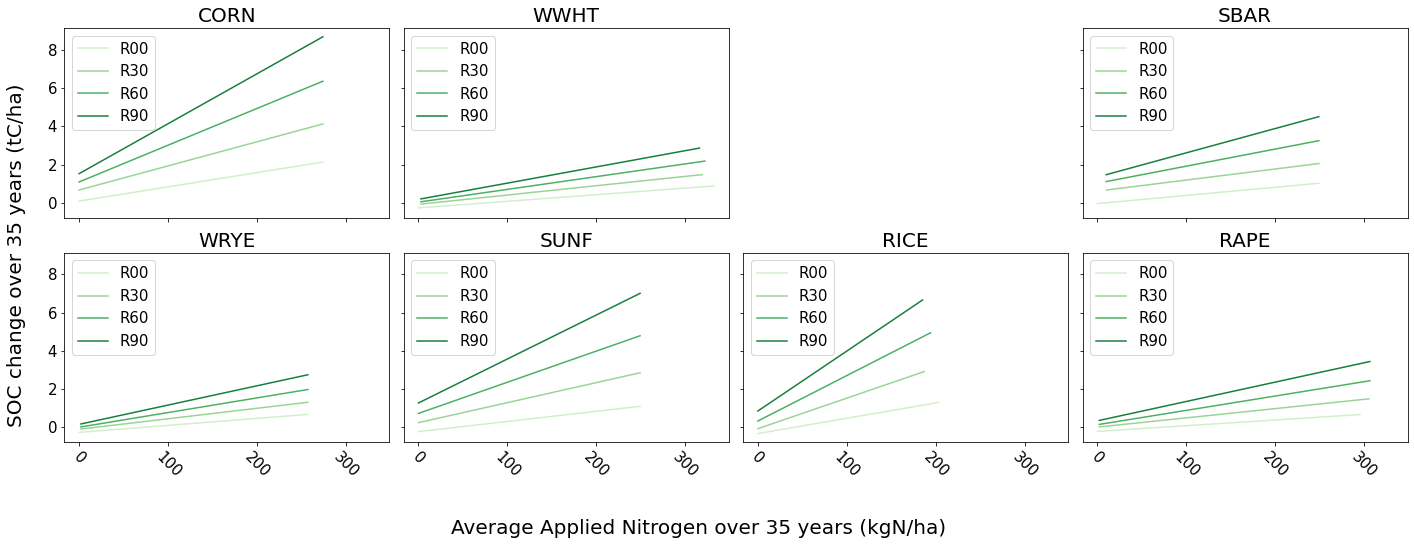

In [64]:
#### EFFECT OF RESIDUE INCORPORATION IN STRATIFYING SOC RESPONSE TO N - LITTLE EFFECT WHEN RESIDUES ARENT APPLIED
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20,8), sharex = True, sharey = True)
crops = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']
# loop over and plot
res = ["R00", "R30", "R60", "R90"]
colors = sns.color_palette("Greens", 4)
for r in range(len(res)):
    crop = 0
    for ax in axs.reshape(-1):
        df = predicted_list[crop]
        no_res = df[df.SCEN.str.contains(res[r])]

        try: 
            z = np.polyfit(no_res.FNO3_AGG, no_res.predicted_mean_OCPD_change*35, 1)
            slope = z[0]
            intercept = z[1]
            p = np.poly1d(z)
            ax.plot(np.arange(no_res.FNO3_AGG.min(), no_res.FNO3_AGG.max(), 1), p(np.arange(no_res.FNO3_AGG.min(), no_res.FNO3_AGG.max(), 1)), c = colors[r], linestyle = "-", label=res[r])
            ax.set_title(crops[crop], fontsize = 20)
            ax.tick_params(axis='x', which='major', labelsize=15, rotation = -45)
            ax.tick_params(axis='y', which='major', labelsize=15)
            ax.legend(loc = "upper left", fontsize = 15)
        except: 
            ax.axis('off')
        crop+=1
    
# x axis label 
fig.supxlabel("Average Applied Nitrogen over 35 years (kgN/ha)", fontsize = 20)
# y axis label 
fig.supylabel("SOC change over 35 years (tC/ha)", rotation='vertical', fontsize = 20)    
plt.tight_layout(rect=[0.02, 0.04, 1, 0.95])
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//linear_N_v_ocpd_META.jpg")

## Linear Relationship between SOC change and Organic Inputs 

In [12]:
#### INVESTIGATE LINEAR RELATIONSHIP BETWEEN SOC CHANGE AND ORGANIC INPUTS 

OCPD_unscaled_list = []
testX_unscaled_list = []
for c in range(len(cluster_lists)):
    # plot preicted values of SOC change versus OC in residues 
    crop_df = cluster_lists[c][-1]
    X_cols = [col for col in crop_df.columns if col not in ['CROP', 'SCEN', 'YLDG', 'YLDF', 'YLC', 'BIOM', 'RW', 'mean_OCPD_change', 'YLDG_std', 'mean_OCPD_change_std']]
    scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test, train_ind, scaler_y, scaler_X = tt_split_scale_SCALER(crop_df, "mean_OCPD_change")

    pred_oc = predict_y_pckl[c][1][-1] 

    # inverse transform the test sets accordingly
    OCPD_unscaled = scaler_y.inverse_transform(pred_oc.reshape(-1, 1))
    testX_unscaled = scaler_X.inverse_transform(scaled_X_test)
    
    OCPD_unscaled_list.append(OCPD_unscaled)
    testX_unscaled_list.append(testX_unscaled)

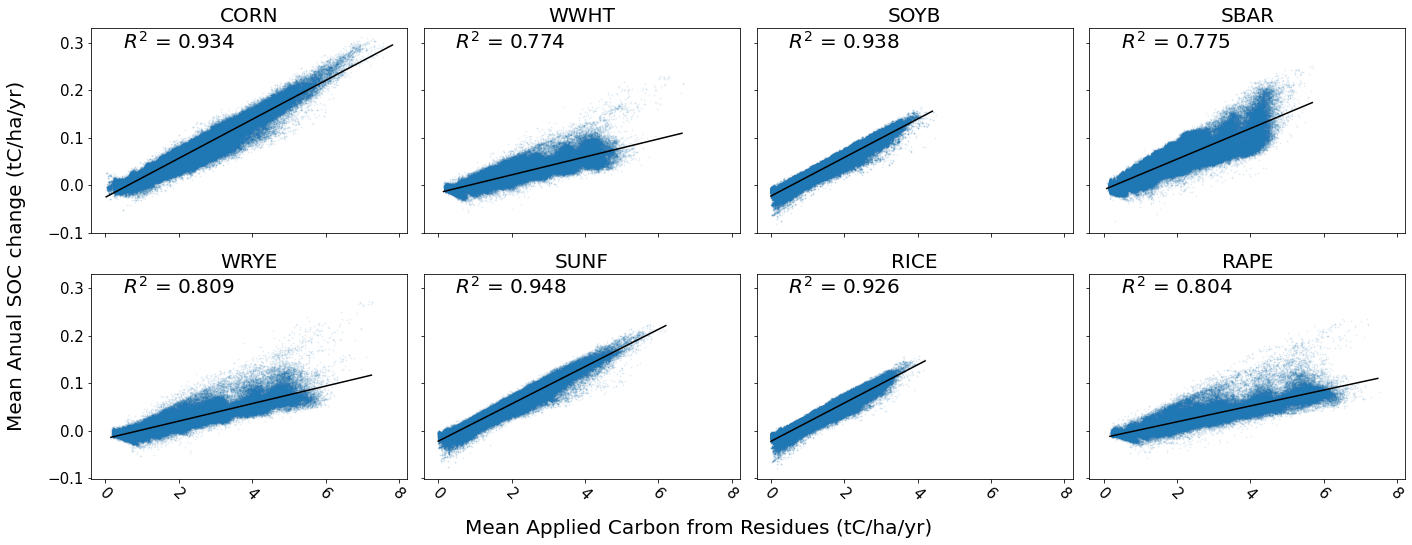

In [68]:
#### LINEAR SOC RESPONSE TO RESIDUE CARBON INCORPORATION
from sklearn.metrics import r2_score
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20,8), sharex = True, sharey = True)
crops = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']
# loop over and plot
crop = 0
for ax in axs.reshape(-1):
    # change to all added C instead of just above ground
    df = predicted_list[crop]
    add_C = (((df['RSDCa']*.75)/1000)+(df['RW']*.55*.42)).to_numpy().flatten()
    OCPD_unscaled = df['predicted_mean_OCPD_change'].to_numpy().flatten()
    
    ax.scatter((add_C), OCPD_unscaled, s = .5, alpha = .1)
    z = np.polyfit(add_C, OCPD_unscaled, 1)

    # just above ground C
#     RSDCa = testX_unscaled_list[crop][:, 34]/1000
#     OCPD_unscaled = OCPD_unscaled_list[crop]
#     ax.scatter((RSDCa), OCPD_unscaled.flatten(), s = .5, alpha = .1)
#     z = np.polyfit(RSDCa, OCPD_unscaled.flatten(), 1)
    slope = z[0]
    intercept = z[1]
    p = np.poly1d(z)
#     ax.plot(np.arange(min(RSDCa), max(RSDCa), .1), p(np.arange(min(RSDCa), max(RSDCa), .1)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
#     ax.text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(OCPD_unscaled, p(RSDCa))), transform=ax.transAxes, fontsize = 20)
    ax.plot(np.arange(min(add_C), max(add_C), .1), p(np.arange(min(add_C), max(add_C), .1)), c = "black", linestyle = "-", label='y={:.2f}x+{:.2f}'.format(slope,intercept))
    ax.text(0.1, .9, "$R^2$ = {:.3f}".format(r2_score(OCPD_unscaled, p(add_C))), transform=ax.transAxes, fontsize = 20)

    ax.set_title(crops[crop], fontsize = 20)
    ax.tick_params(axis='x', which='major', labelsize=15, rotation = -45)
    ax.tick_params(axis='y', which='major', labelsize=15)
    crop+=1
    
# x axis label 
fig.supxlabel("Mean Applied Carbon from Residues (tC/ha/yr)", fontsize = 20)

# y axis label 
fig.supylabel("Mean Anual SOC change (tC/ha/yr)", rotation='vertical', fontsize = 20)    
plt.tight_layout(rect=[0.02, 0.00, 1, 0.95])
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//linear_resC_v_ocpd.jpg")


## MAPS

In [70]:
# get soil and climate clusters 
clim_info = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//climate_PCA_x_simUID.csv")[['SimUID', 'k_mean_cluster']]
soil_info = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//SimUID_List.txt", sep = ';')[['SimUID', 'TEXTURE']]
loc_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt")
merged1 = loc_df.merge(clim_info, how = 'left', on = 'SimUID')
merged2 = merged1.merge(soil_info, how = 'left', on = 'SimUID')
merged2.dropna(inplace = True)

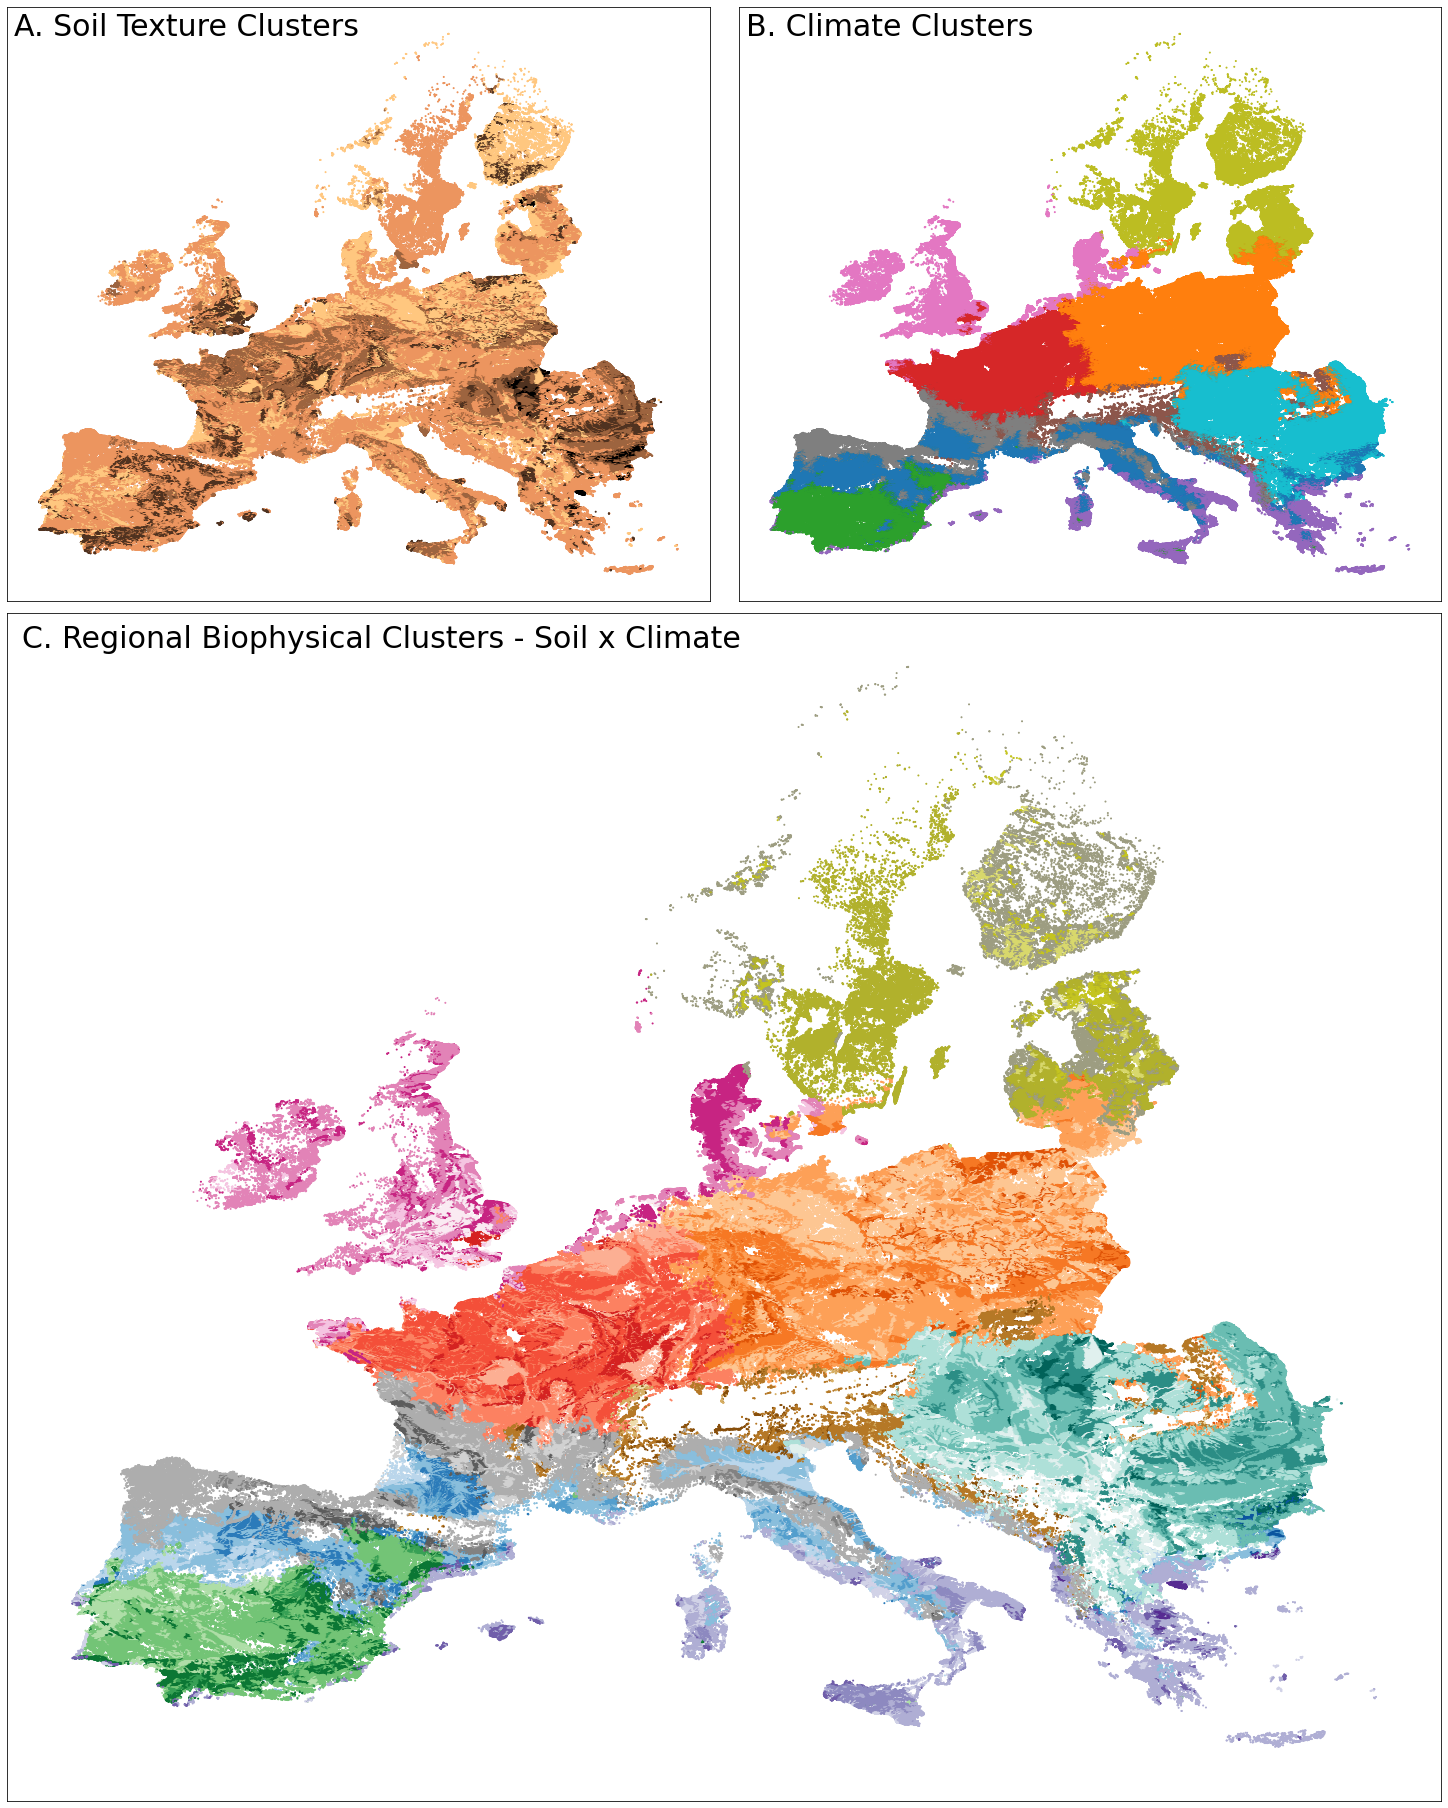

In [71]:
# MOSAIC PLOT OF CLUSTERS AND FINAL SUBGROUPS
fig, axs = plt.subplot_mosaic([['soil', 'clim'], 
                               ['final', 'final'], 
                               ['final', 'final']], figsize = (20, 25),
                              constrained_layout=True)

# define colormaps
scolm = cm.get_cmap('copper_r', 5)
ccolm = cm.get_cmap("tab10", 10)

# soil plot
# axs['soil'].set_title("Soil Texture Classes", fontsize = 20)
axs['soil'].text(.01, .99, "A. Soil Texture Clusters", ha='left', va='top', transform=axs['soil'].transAxes, fontsize = 30)
axs['soil'].scatter(merged2.X, merged2.Y, s = 1, c = merged2.TEXTURE, cmap = scolm, edgecolor = None, alpha = 1)
axs['soil'].grid(False)
axs['soil'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# soilcbar = plt.colorbar()
# soilcbar.axs['soil'].tick_params(labelsize=20)
# soilcbar.set_label('Soil Texture', rotation = 270, fontsize = 20, labelpad = 30)

# climate plot
# axs['clim'].set_title("Climate Clusters", fontsize = 20)
axs['clim'].text(.01, .99, "B. Climate Clusters", ha='left', va='top', transform=axs['clim'].transAxes, fontsize = 30)
axs['clim'].scatter(merged2.X, merged2.Y, s = 1, c = merged2.k_mean_cluster, cmap = ccolm, edgecolor = None, alpha = 1)
axs['clim'].grid(False)
axs['clim'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# climcbar = plt.colorbar()
# climcbar.axs['clim'].tick_params(labelsize=20)
# climcbar.set_label('Climate Cluster', rotation = 270, fontsize = 20, labelpad = 30)


# final plot
# axs['final'].set_title("Regional Biophysical Clusters - Soil x Climate", fontsize = 20)
axs['final'].text(.01, .99, "C. Regional Biophysical Clusters - Soil x Climate", ha='left', va='top', transform=axs['final'].transAxes, fontsize = 30)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 0].X, merged2[merged2.k_mean_cluster == 0].Y, s = 1, c = merged2[merged2.k_mean_cluster == 0].TEXTURE, cmap = ListedColormap(sns.color_palette("Blues", 6).as_hex()[1:]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 1].X, merged2[merged2.k_mean_cluster == 1].Y, s = 1, c = merged2[merged2.k_mean_cluster == 1].TEXTURE, cmap = ListedColormap(sns.color_palette("Oranges", 6).as_hex()[1:]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 2].X, merged2[merged2.k_mean_cluster == 2].Y, s = 1, c = merged2[merged2.k_mean_cluster == 2].TEXTURE, cmap = ListedColormap(sns.color_palette("Greens", 5).as_hex()[1:]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 3].X, merged2[merged2.k_mean_cluster == 3].Y, s = 1, c = merged2[merged2.k_mean_cluster == 3].TEXTURE, cmap = ListedColormap(sns.color_palette("Reds", 6).as_hex()[1:]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 4].X, merged2[merged2.k_mean_cluster == 4].Y, s = 1, c = merged2[merged2.k_mean_cluster == 4].TEXTURE, cmap = ListedColormap(sns.color_palette("Purples", 6).as_hex()[1:]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 5].X, merged2[merged2.k_mean_cluster == 5].Y, s = 1, c = merged2[merged2.k_mean_cluster == 5].TEXTURE, cmap = ListedColormap(sns.color_palette("BrBG", 10).as_hex()[:5]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 6].X, merged2[merged2.k_mean_cluster == 6].Y, s = 1, c = merged2[merged2.k_mean_cluster == 6].TEXTURE, cmap = ListedColormap(sns.color_palette("PiYG", 8).as_hex()[:4]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 7].X, merged2[merged2.k_mean_cluster == 7].Y, s = 1, c = merged2[merged2.k_mean_cluster == 7].TEXTURE, cmap = ListedColormap(sns.color_palette("Greys", 6).as_hex()[1:]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 8].X, merged2[merged2.k_mean_cluster == 8].Y, s = 1, c = merged2[merged2.k_mean_cluster == 8].TEXTURE, cmap = ListedColormap(sns.color_palette("gist_stern", 12).as_hex()[-5:]), edgecolor = None, alpha = 1)
axs['final'].scatter(merged2[merged2.k_mean_cluster == 9].X, merged2[merged2.k_mean_cluster == 9].Y, s = 1, c = merged2[merged2.k_mean_cluster == 9].TEXTURE, cmap = ListedColormap(sns.color_palette("BrBG", 10).as_hex()[-5:]), edgecolor = None, alpha = 1)
axs['final'].grid(False)
axs['final'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//regional_biophysical_clusters.jpg")